### Data filtering and repackaging.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
# plt.style.use('seaborn-v0_8-colorblind')
# plt.rcParams['axes.grid'] = False

from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [2]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

In [3]:
original_features_rband_csv = base_directory + "Original_Data/features_QSO_AGN_Blazar_ZTF_DR6_lcs_rband_all.csv"
original_features_gband_csv = base_directory + "Original_Data/features_QSO_AGN_Blazar_ZTF_DR6_lcs_gband_all.csv"

original_lightcurves_rband_parquet = base_directory + "Original_Data/QSO_AGN_Blazar_ZTF_DR6_lcs_rband.parquet"
original_lightcurves_gband_parquet = base_directory + "Original_Data/QSO_AGN_Blazar_ZTF_DR6_lcs_gband.parquet"

panstarrs_pointsource_csv = base_directory + "Original_Data/QSO_AGN_Blazar_sample_milliquas_roma_ps_score_pointsources.csv"

# These files do not exist, they are save paths for later on in the script
original_features_by_name_parquet = base_directory + "original_features_by_name.parquet"
original_features_by_oid_parquet = base_directory + "original_features_by_oid.parquet"

filtered_lightcurves_by_name_pkl = base_directory + "lightcurves_by_name_original_cadence.pkl"
filtered_lightcurves_by_oid_pkl = base_directory + "lightcurves_by_oid_original_cadence.pkl"

### Let's examine the panstarrs DF

In [4]:
panstarrs = pd.read_csv(panstarrs_pointsource_csv)
panstarrs

,ztf_id,name,ra,dec,z,type,ps_score,index
0,69643482935592723,PKS 2310-322,348.293577,-31.964667,0.330,A2X,0.746652,-31
1,69663533360606047,2QZ J233320.6-315643,353.336074,-31.945295,0.380,A,0.744333,-31
2,69680910605210790,PKS 0602-31,91.060520,-31.932916,0.450,ARX,0.891042,-31
3,69740606425600546,NVSS J040234-315301,60.642635,-31.883150,0.290,ARX,0.538815,-31
4,69751947509402083,2MASS J12590021-3152245,194.750876,-31.873526,0.290,A,0.961000,-31
...,...,...,...,...,...,...,...,...
33711,210033265336507006,3HSPJ214609.1+850148,326.534157,85.030163,0.300,B,0.970625,85
33712,210192401321597205,WN B1609.6+8517,240.132089,85.163661,NaN,BRX,0.894435,85
33713,210991056360258301,[MML2015] 5BZQ J0702+8549,105.636292,85.831189,1.059,QSO RLoud flat radio sp.,0.958812,85
33714,211441424285588054,[MML2015] 5BZB J0929+8612,142.429417,86.205919,NaN,BL Lac,0.998750,86


In [5]:
panstarrs = pd.read_csv(panstarrs_pointsource_csv, usecols=['name', 'type', 'ps_score', 'z'])
panstarrs

,name,z,type,ps_score
0,PKS 2310-322,0.330,A2X,0.746652
1,2QZ J233320.6-315643,0.380,A,0.744333
2,PKS 0602-31,0.450,ARX,0.891042
3,NVSS J040234-315301,0.290,ARX,0.538815
4,2MASS J12590021-3152245,0.290,A,0.961000
...,...,...,...,...
33711,3HSPJ214609.1+850148,0.300,B,0.970625
33712,WN B1609.6+8517,NaN,BRX,0.894435
33713,[MML2015] 5BZQ J0702+8549,1.059,QSO RLoud flat radio sp.,0.958812
33714,[MML2015] 5BZB J0929+8612,NaN,BL Lac,0.998750


**Are there duplicates in `panstarrs`?**

In [6]:
name_duplictate_counts = panstarrs['name'].value_counts().value_counts()
for number_repetition, instances_number_repetition in name_duplictate_counts.items():
    print(f'There are {instances_number_repetition:,} objects repeated {number_repetition:,} times in the panstarrs DF.')

There are 31,934 objects repeated 1 times in the panstarrs DF.
There are 891 objects repeated 2 times in the panstarrs DF.


In [7]:
grouped = panstarrs.groupby(by='name', observed=True)
duplicates_have_different_types = False
duplicates_have_different_z = False

for name, df in grouped:
    if df['type'].nunique() > 1:
        duplicates_have_different_types = True
    if df['z'].nunique() > 1:
        duplicates_have_different_z = True

if duplicates_have_different_types:
    print('Caution: Duplicate objects in panstarrs DF found to have different reported types!')
else:
    print('Duplicate objects in panstarrs DF found to have the same reported types. All good!')

if duplicates_have_different_z:
    print('Caution: Duplicate objects in panstarrs DF found to have different reported redshifts!')
else:
    print('Duplicate objects in panstarrs DF found to have the same reported redshifts. All good!')

grouped = np.nan

Duplicate objects in panstarrs DF found to have the same reported types. All good!
Duplicate objects in panstarrs DF found to have the same reported redshifts. All good!


**Are all sources in `panstarrs` point sources?**

In [8]:
panstarrs = panstarrs.groupby("name", as_index=False).agg({"type": "first", "ps_score": "mean", "z": "mean"})

panstarrs_total_type_num = panstarrs['type'].unique().size
panstarrs_total_objects_num = panstarrs['name'].unique().size
print(f'There are {panstarrs_total_type_num:,} unique types reported in the panstarrs DF.')
print(f'There are {panstarrs_total_objects_num:,} unique objects reported in the panstarrs DF.', '\n')

panstarrs = panstarrs[panstarrs['ps_score'] >= 0.5]
panstarrs_ps_type_num = panstarrs['type'].unique().size
panstarrs_ps_objects_num = panstarrs['name'].unique().size
print(f'There are {panstarrs_ps_type_num:,} pointsource types reported in the panstarrs DF.')
print(f'There are {panstarrs_ps_objects_num:,} pointsource objects reported in the panstarrs DF.')

panstarrs = panstarrs.drop(columns='ps_score')
panstarrs

There are 29 unique types reported in the panstarrs DF.
There are 32,825 unique objects reported in the panstarrs DF. 

There are 29 pointsource types reported in the panstarrs DF.
There are 32,825 pointsource objects reported in the panstarrs DF.


,name,type,z
0,1AXG J000605+2031,AX,0.380
1,1AXG J035008-1149,AX,0.450
2,1AXG J102337+1936,AX,0.400
3,1AXG J103934+5330,AX,0.220
4,1AXG J141240-1209,ARX,0.240
...,...,...,...
32820,[MML2015] 5BZU J2303-1841,Blazar Uncertain type,0.129
32821,[MML2015] 5BZU J2352+3947,Blazar Uncertain type,0.858
32822,[MML2015] 5BZU J2354-0405,Blazar Uncertain type,0.720
32823,eHAQ0142+0257,QR,2.310


This means that all the objects reported in the panstarrs DF are pointsources.

**What is the distribution of sources in `panstarrs`?**

In [9]:
num_na_redshifts = panstarrs.z.isna().sum()

print(f"Of {panstarrs.shape[0]:,} objects, {num_na_redshifts:,} ({num_na_redshifts / panstarrs.shape[0]:.2%}) do not have a reported redshift.")

Of 32,825 objects, 666 (2.03%) do not have a reported redshift.


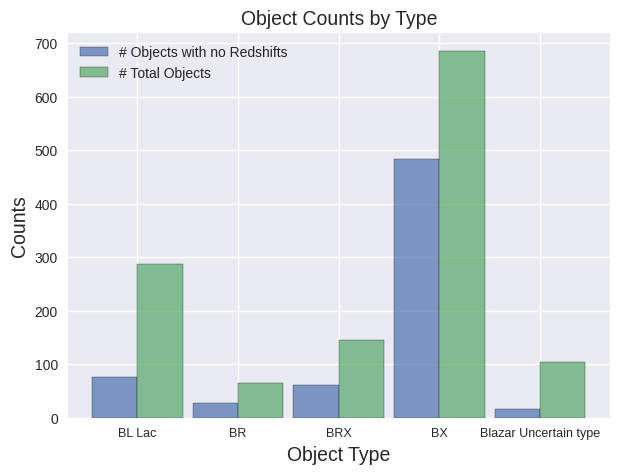

In [10]:
no_redshift_type_array = panstarrs.query("z.isna()").type
with_redshift_type_array = panstarrs.query("type in @no_redshift_type_array").type

plt.figure(figsize=(7, 5))

counts, bin_edges, patches = plt.hist((no_redshift_type_array, with_redshift_type_array), bins=no_redshift_type_array.unique().size,
                                edgecolor='black', alpha=0.7, align='mid', rwidth=0.9, label=('# Objects with no Redshifts', '# Total Objects'))

categories = sorted(no_redshift_type_array.unique())
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.xticks(bin_centers, labels=categories, rotation=0, size=9)
plt.title('Object Counts by Type', size=14)
plt.xlabel('Object Type', size=14)
plt.ylabel('Counts', size=14)
plt.legend()
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_32408/115359017.py:16: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}$ Counts', size=18)


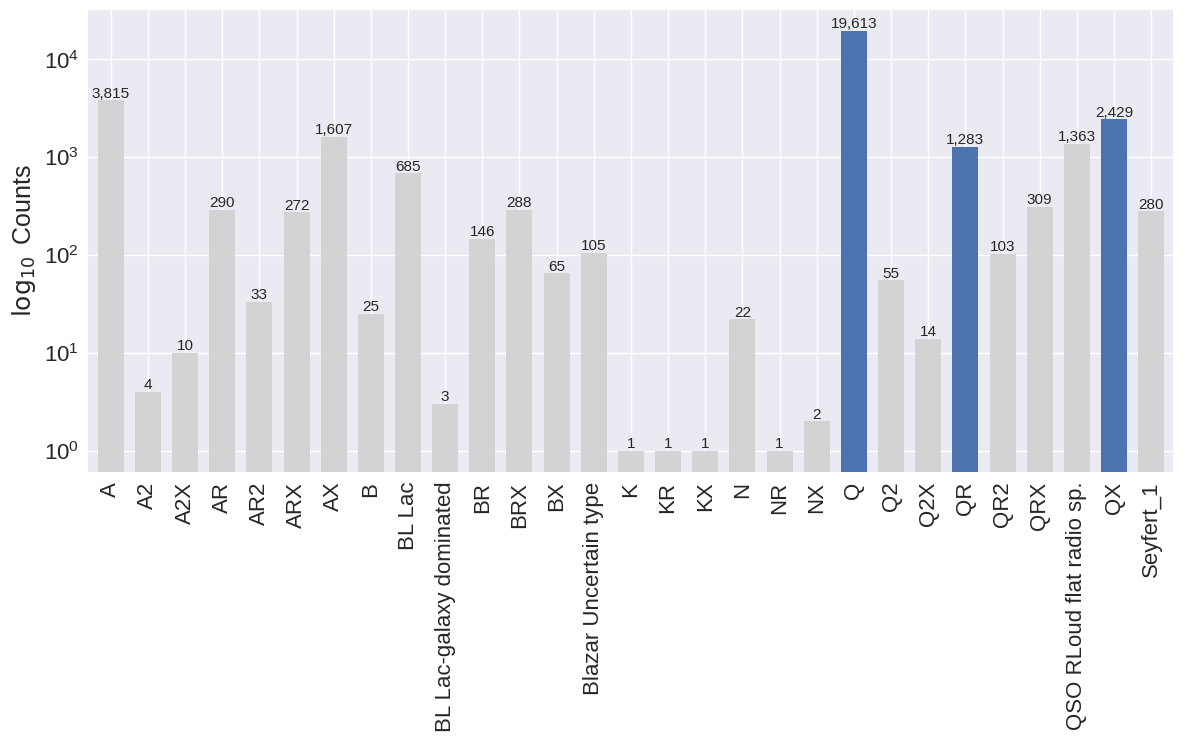

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))


counts = panstarrs['type'].value_counts().sort_index()

highlight = ["Q", "QR", "QX"]
colors = ['C0' if label in highlight else 'lightgray' for label in counts.index]

counts.plot(kind='bar', width=0.7, color=colors)

for i, count in enumerate(counts):
    ax.text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=11)

plt.yscale('log')
plt.xlabel('')
plt.ylabel('$\log_{10}$ Counts', size=18)
plt.xticks(size=16)
plt.yticks(size=16)

plt.show()

**We will also plot the $z$ distribution**

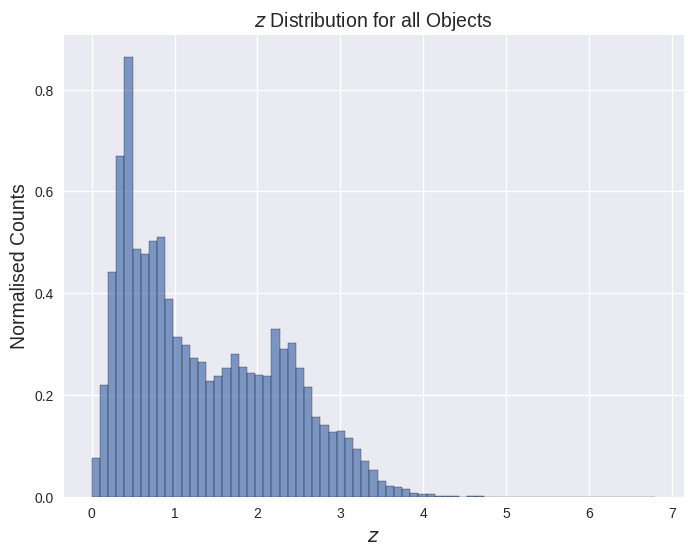

In [12]:
plt.figure(figsize=(8, 6))

counts, bin_edges, _ = plt.hist(panstarrs.z, bins='fd', edgecolor='black', alpha=0.7, density=True)

# categories = sorted(set(type_array))
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# plt.yscale('log')
# plt.xticks(bin_centers, labels=categories, rotation=90)
plt.title('$z$ Distribution for all Objects', size=14)
plt.xlabel('$z$', size=14)
plt.ylabel('Normalised Counts', size=14)
plt.show()

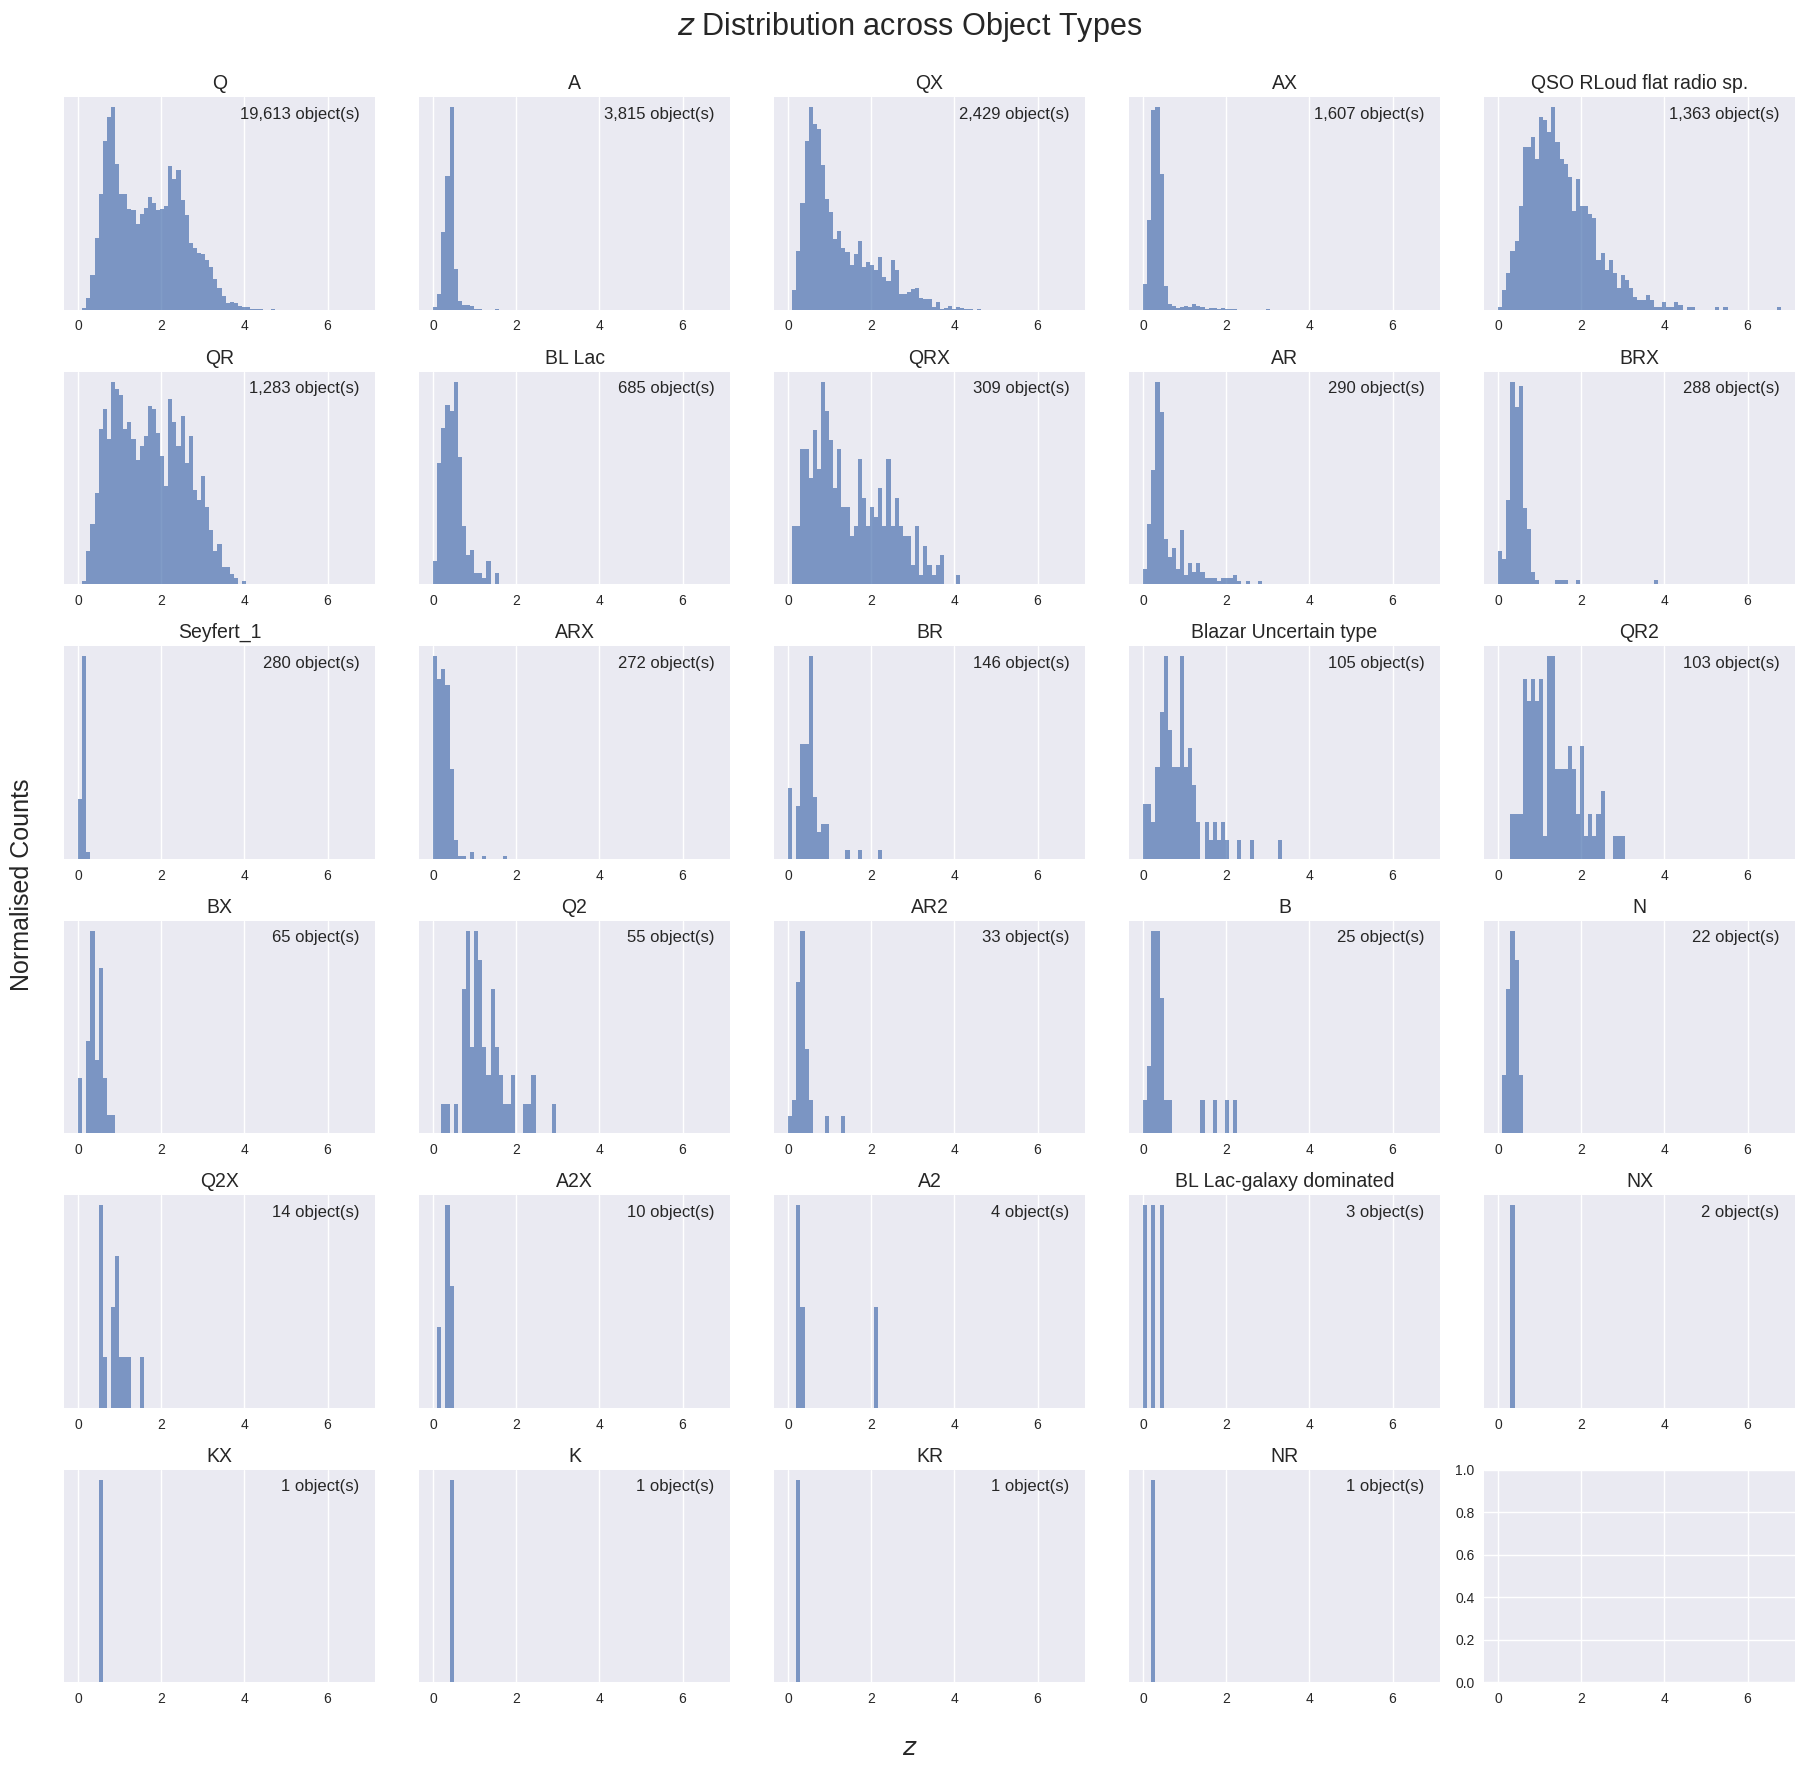

In [13]:
nrows, ncols = 6, 5
object_types = panstarrs.type.value_counts().index
nbins = bin_edges

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3.5 * ncols), sharex=True)

for ax, object_type in zip(axs.flatten(), object_types):
    redshifts = panstarrs.query("type == @object_type").z
    ax.hist(redshifts, bins=nbins, alpha=0.7, density=True)
    ax.set_title(f'{object_type}', size=14)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_visible(False)
    ax.text(x=0.95, y=0.9, s=f'{redshifts.size:,} object(s)', transform=ax.transAxes, fontsize=12, ha='right')
    # ax.legend()

fig.suptitle('$z$ Distribution across Object Types', size=22, y=1)
fig.supylabel('Normalised Counts', size=18, x=0)
fig.supxlabel('$z$', size=18, y=0)

plt.tight_layout()
plt.show()

### Saving Lightcurves

In [14]:
lightcurves_relevant_columns = ['name', 'ra', 'dec', 'oid_alerce', 'mjd', 'mag', 'magerr', 'catflags', 'filtercode']
lightcurves_r = pd.read_parquet(original_lightcurves_rband_parquet, columns=lightcurves_relevant_columns)
lightcurves_g = pd.read_parquet(original_lightcurves_gband_parquet, columns=lightcurves_relevant_columns)
lightcurves = pd.concat([lightcurves_r, lightcurves_g], axis=0, ignore_index=True).replace([np.inf, -np.inf], np.nan)

lightcurves_r, lightcurves_g = np.nan, np.nan

total_lightcurve_dets_pre_filter = len(lightcurves)
print(f"There are a total of {lightcurves.oid_alerce.unique().size:,} OIDs reported in Paula's data originally.")
print(f'There are a total of {total_lightcurve_dets_pre_filter:,} detections in the lightcurve DF pre-filtering.')

There are a total of 116,374 OIDs reported in Paula's data originally.
There are a total of 26,418,191 detections in the lightcurve DF pre-filtering.


In [15]:
lightcurves = lightcurves[(lightcurves['catflags'] == 0) & (abs(lightcurves['magerr']) < 1) & (lightcurves['magerr'] != 0)]
lightcurves = lightcurves.drop(columns='catflags').reset_index(drop=True)
lightcurves = lightcurves.rename(columns={"filtercode": "band"})
lightcurves["band"] = lightcurves["band"].replace({"zr": "r", "zg": "g"})
total_lightcurve_dets_post_filter = len(lightcurves)

print(f'Catflags and magerr filters removed a total of {total_lightcurve_dets_pre_filter - total_lightcurve_dets_post_filter:,} detections ({(total_lightcurve_dets_pre_filter - total_lightcurve_dets_post_filter) / total_lightcurve_dets_pre_filter:.2%}).')
print(f'Catflags and magerr filters left us with {lightcurves.oid_alerce.unique().size:,} unique OIDs')

Catflags and magerr filters removed a total of 60,745 detections (0.23%).
Catflags and magerr filters left us with 116,258 unique OIDs


In [16]:
lightcurves = lightcurves.merge(right=panstarrs, on='name', how='inner')
print(f'After merging lightcurves with panstarrs we are left with {lightcurves.oid_alerce.unique().size:,} unique OIDs.')
print(f'After merging lightcurves with panstarrs we are left with {lightcurves.shape[0]:,} individual observations.')
print(f'After merging lightcurves with panstarrs we are left with {lightcurves.name.unique().size:,} individual objects.')
print(f'After merging lightcurves with panstarrs we are left with {lightcurves.type.unique().size:,} unique types.')

lightcurves

After merging lightcurves with panstarrs we are left with 116,258 unique OIDs.
After merging lightcurves with panstarrs we are left with 26,357,446 individual observations.
After merging lightcurves with panstarrs we are left with 32,231 individual objects.
After merging lightcurves with panstarrs we are left with 29 unique types.


,name,ra,dec,oid_alerce,mjd,mag,magerr,band,type,z
0,2QZ J025819.5-275415,44.581626,-27.904341,251203400005429,58361.501065,19.549748,0.132820,r,A,0.27
1,2QZ J025819.5-275415,44.581675,-27.904382,251203400005429,58364.515799,19.796310,0.155033,r,A,0.27
2,2QZ J025819.5-275415,44.581563,-27.904320,251203400005429,58365.501227,19.457630,0.124800,r,A,0.27
3,2QZ J025819.5-275415,44.581542,-27.904358,251203400005429,58368.459259,19.657337,0.142434,r,A,0.27
4,2QZ J025819.5-275415,44.581625,-27.904328,251203400005429,58370.521227,19.672159,0.143772,r,A,0.27
...,...,...,...,...,...,...,...,...,...,...
26357441,H 1420#24,213.912968,9.737940,529103200000097,59317.277535,18.280655,0.036006,g,Q,2.02
26357442,H 1420#24,213.912983,9.737944,529103200000097,59321.358484,18.292160,0.036255,g,Q,2.02
26357443,H 1420#24,213.912993,9.737927,529103200000097,59323.295012,18.258877,0.035541,g,Q,2.02
26357444,H 1420#24,213.913003,9.737940,529103200000097,59325.361481,18.269554,0.035768,g,Q,2.02


#### Saving lightcurves by OIDs

In [17]:
oid_grouped = lightcurves.groupby(by='oid_alerce', observed=True)
lightcurves_by_oid_dict_list = []

for oid, oid_df in tqdm(oid_grouped):
    if len(oid_df) < 2:
        continue
    oid_df = oid_df.sort_values(by='mjd')
    mjds, mags, magerrs = oid_df['mjd'].to_numpy(), oid_df['mag'].to_numpy(), oid_df['magerr'].to_numpy()

    lightcurves_by_oid_dict = {'oid_alerce': oid,
                               'name': oid_df.name.iloc[0],
                               'ra': oid_df.ra.mean(),
                               'dec': oid_df.dec.mean(),
                               'z': oid_df.z.mean(),
                               'type': oid_df.type.iloc[0],
                               'band': oid_df.band.iloc[0],
                               'timespan_good': mjds.max() - mjds.min(),
                               'n_good_det': mjds.size}
    
    lightcurves_by_oid_dict['lightcurve'] = np.column_stack([mjds, mags, magerrs])
    lightcurves_by_oid_dict_list.append(lightcurves_by_oid_dict)

  0%|          | 0/116258 [00:00<?, ?it/s]

In [18]:
lightcurves_by_oid = pd.DataFrame(lightcurves_by_oid_dict_list)
lightcurves_by_oid_dict = np.nan

lightcurves_by_oid

,oid_alerce,name,ra,dec,z,type,band,timespan_good,n_good_det,lightcurve
0,202116200001134,[MML2015] 5BZQ J0121-2806,20.253078,-28.106155,3.119,QSO RLoud flat radio sp.,g,91.813565,22,"[[59128.3131713, 19.233299300000002, 0.1209965..."
1,202116200001815,MS 01172-2837,19.898718,-28.358674,0.340,AX,g,91.813565,30,"[[59128.3131713, 16.2171993, 0.0201570522], [5..."
2,245101400008768,[MML2015] 5BZQ J0017-2748,4.495864,-27.805960,1.169,QSO RLoud flat radio sp.,g,858.730567,50,"[[58313.4805208, 20.5058784, 0.177769601000000..."
3,245103300011108,6QZ J000024.0-275153,0.100087,-27.864805,0.450,A,g,879.646204,105,"[[58335.4812731, 17.6542168, 0.0335438251], [5..."
4,245103400001552,2QZ J000355.8-272721,0.982512,-27.455891,0.340,A,g,864.648009,82,"[[58313.4805208, 19.6845932, 0.130522713], [58..."
...,...,...,...,...,...,...,...,...,...,...
116010,1893209300006536,RXS J23408+8015,355.225979,80.254463,0.270,BX,r,57.801076,15,"[[58740.4621412, 16.974130600000002, 0.0169909..."
116011,1893209400007404,CGRaBS J2346+8007,356.606758,80.132020,NaN,BRX,r,57.801076,15,"[[58740.4621412, 19.603391600000002, 0.1072620..."
116012,1893216400001045,[MML2015] 5BZQ J2133+8239,323.391978,82.651695,2.350,QSO RLoud flat radio sp.,r,57.801076,15,"[[58740.4621412, 18.8515949, 0.0735387653], [5..."
116013,1896203200014101,[MML2015] 5BZB J0508+8432,77.176442,84.534606,1.340,BL Lac,r,57.856840,6,"[[58770.3863657, 18.7142582, 0.0609602667], [5..."


In [19]:
lightcurves_by_oid.isna().sum()

oid_alerce          0
name                0
ra                  0
dec                 0
z                1999
type                0
band                0
timespan_good       0
n_good_det          0
lightcurve          0
dtype: int64

In [20]:
lightcurves_by_oid.to_pickle(filtered_lightcurves_by_oid_pkl)
# lightcurves_by_oid = np.nan

# lightcurves_by_oid = pd.read_pickle(filtered_lightcurves_by_oid_pkl)

lightcurves_by_oid

,oid_alerce,name,ra,dec,z,type,band,timespan_good,n_good_det,lightcurve
0,202116200001134,[MML2015] 5BZQ J0121-2806,20.253078,-28.106155,3.119,QSO RLoud flat radio sp.,g,91.813565,22,"[[59128.3131713, 19.233299300000002, 0.1209965..."
1,202116200001815,MS 01172-2837,19.898718,-28.358674,0.340,AX,g,91.813565,30,"[[59128.3131713, 16.2171993, 0.0201570522], [5..."
2,245101400008768,[MML2015] 5BZQ J0017-2748,4.495864,-27.805960,1.169,QSO RLoud flat radio sp.,g,858.730567,50,"[[58313.4805208, 20.5058784, 0.177769601000000..."
3,245103300011108,6QZ J000024.0-275153,0.100087,-27.864805,0.450,A,g,879.646204,105,"[[58335.4812731, 17.6542168, 0.0335438251], [5..."
4,245103400001552,2QZ J000355.8-272721,0.982512,-27.455891,0.340,A,g,864.648009,82,"[[58313.4805208, 19.6845932, 0.130522713], [58..."
...,...,...,...,...,...,...,...,...,...,...
116010,1893209300006536,RXS J23408+8015,355.225979,80.254463,0.270,BX,r,57.801076,15,"[[58740.4621412, 16.974130600000002, 0.0169909..."
116011,1893209400007404,CGRaBS J2346+8007,356.606758,80.132020,NaN,BRX,r,57.801076,15,"[[58740.4621412, 19.603391600000002, 0.1072620..."
116012,1893216400001045,[MML2015] 5BZQ J2133+8239,323.391978,82.651695,2.350,QSO RLoud flat radio sp.,r,57.801076,15,"[[58740.4621412, 18.8515949, 0.0735387653], [5..."
116013,1896203200014101,[MML2015] 5BZB J0508+8432,77.176442,84.534606,1.340,BL Lac,r,57.856840,6,"[[58770.3863657, 18.7142582, 0.0609602667], [5..."


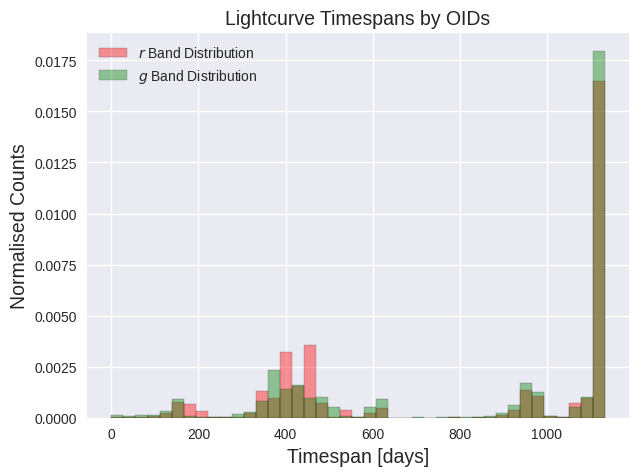

In [21]:
r_timespan_good = lightcurves_by_oid.query("band == 'r'").timespan_good
g_timespan_good = lightcurves_by_oid.query("band == 'g'").timespan_good

_, bins = np.histogram(r_timespan_good.to_list() + g_timespan_good.to_list(), bins='fd', density=True)


plt.figure(figsize=(7, 5))

plt.hist(r_timespan_good, bins=bins, edgecolor='black', alpha=0.4, color='r', label='$r$ Band Distribution', density=True)
plt.hist(g_timespan_good, bins=bins, edgecolor='black', alpha=0.4, color='g', label='$g$ Band Distribution', density=True)

# plt.yscale('log')
# plt.xticks(bin_centers, labels=categories, rotation=0, size=9)
plt.title('Lightcurve Timespans by OIDs', size=14)
plt.xlabel('Timespan [days]', size=14)
plt.ylabel('Normalised Counts', size=14)
plt.legend()
plt.show()

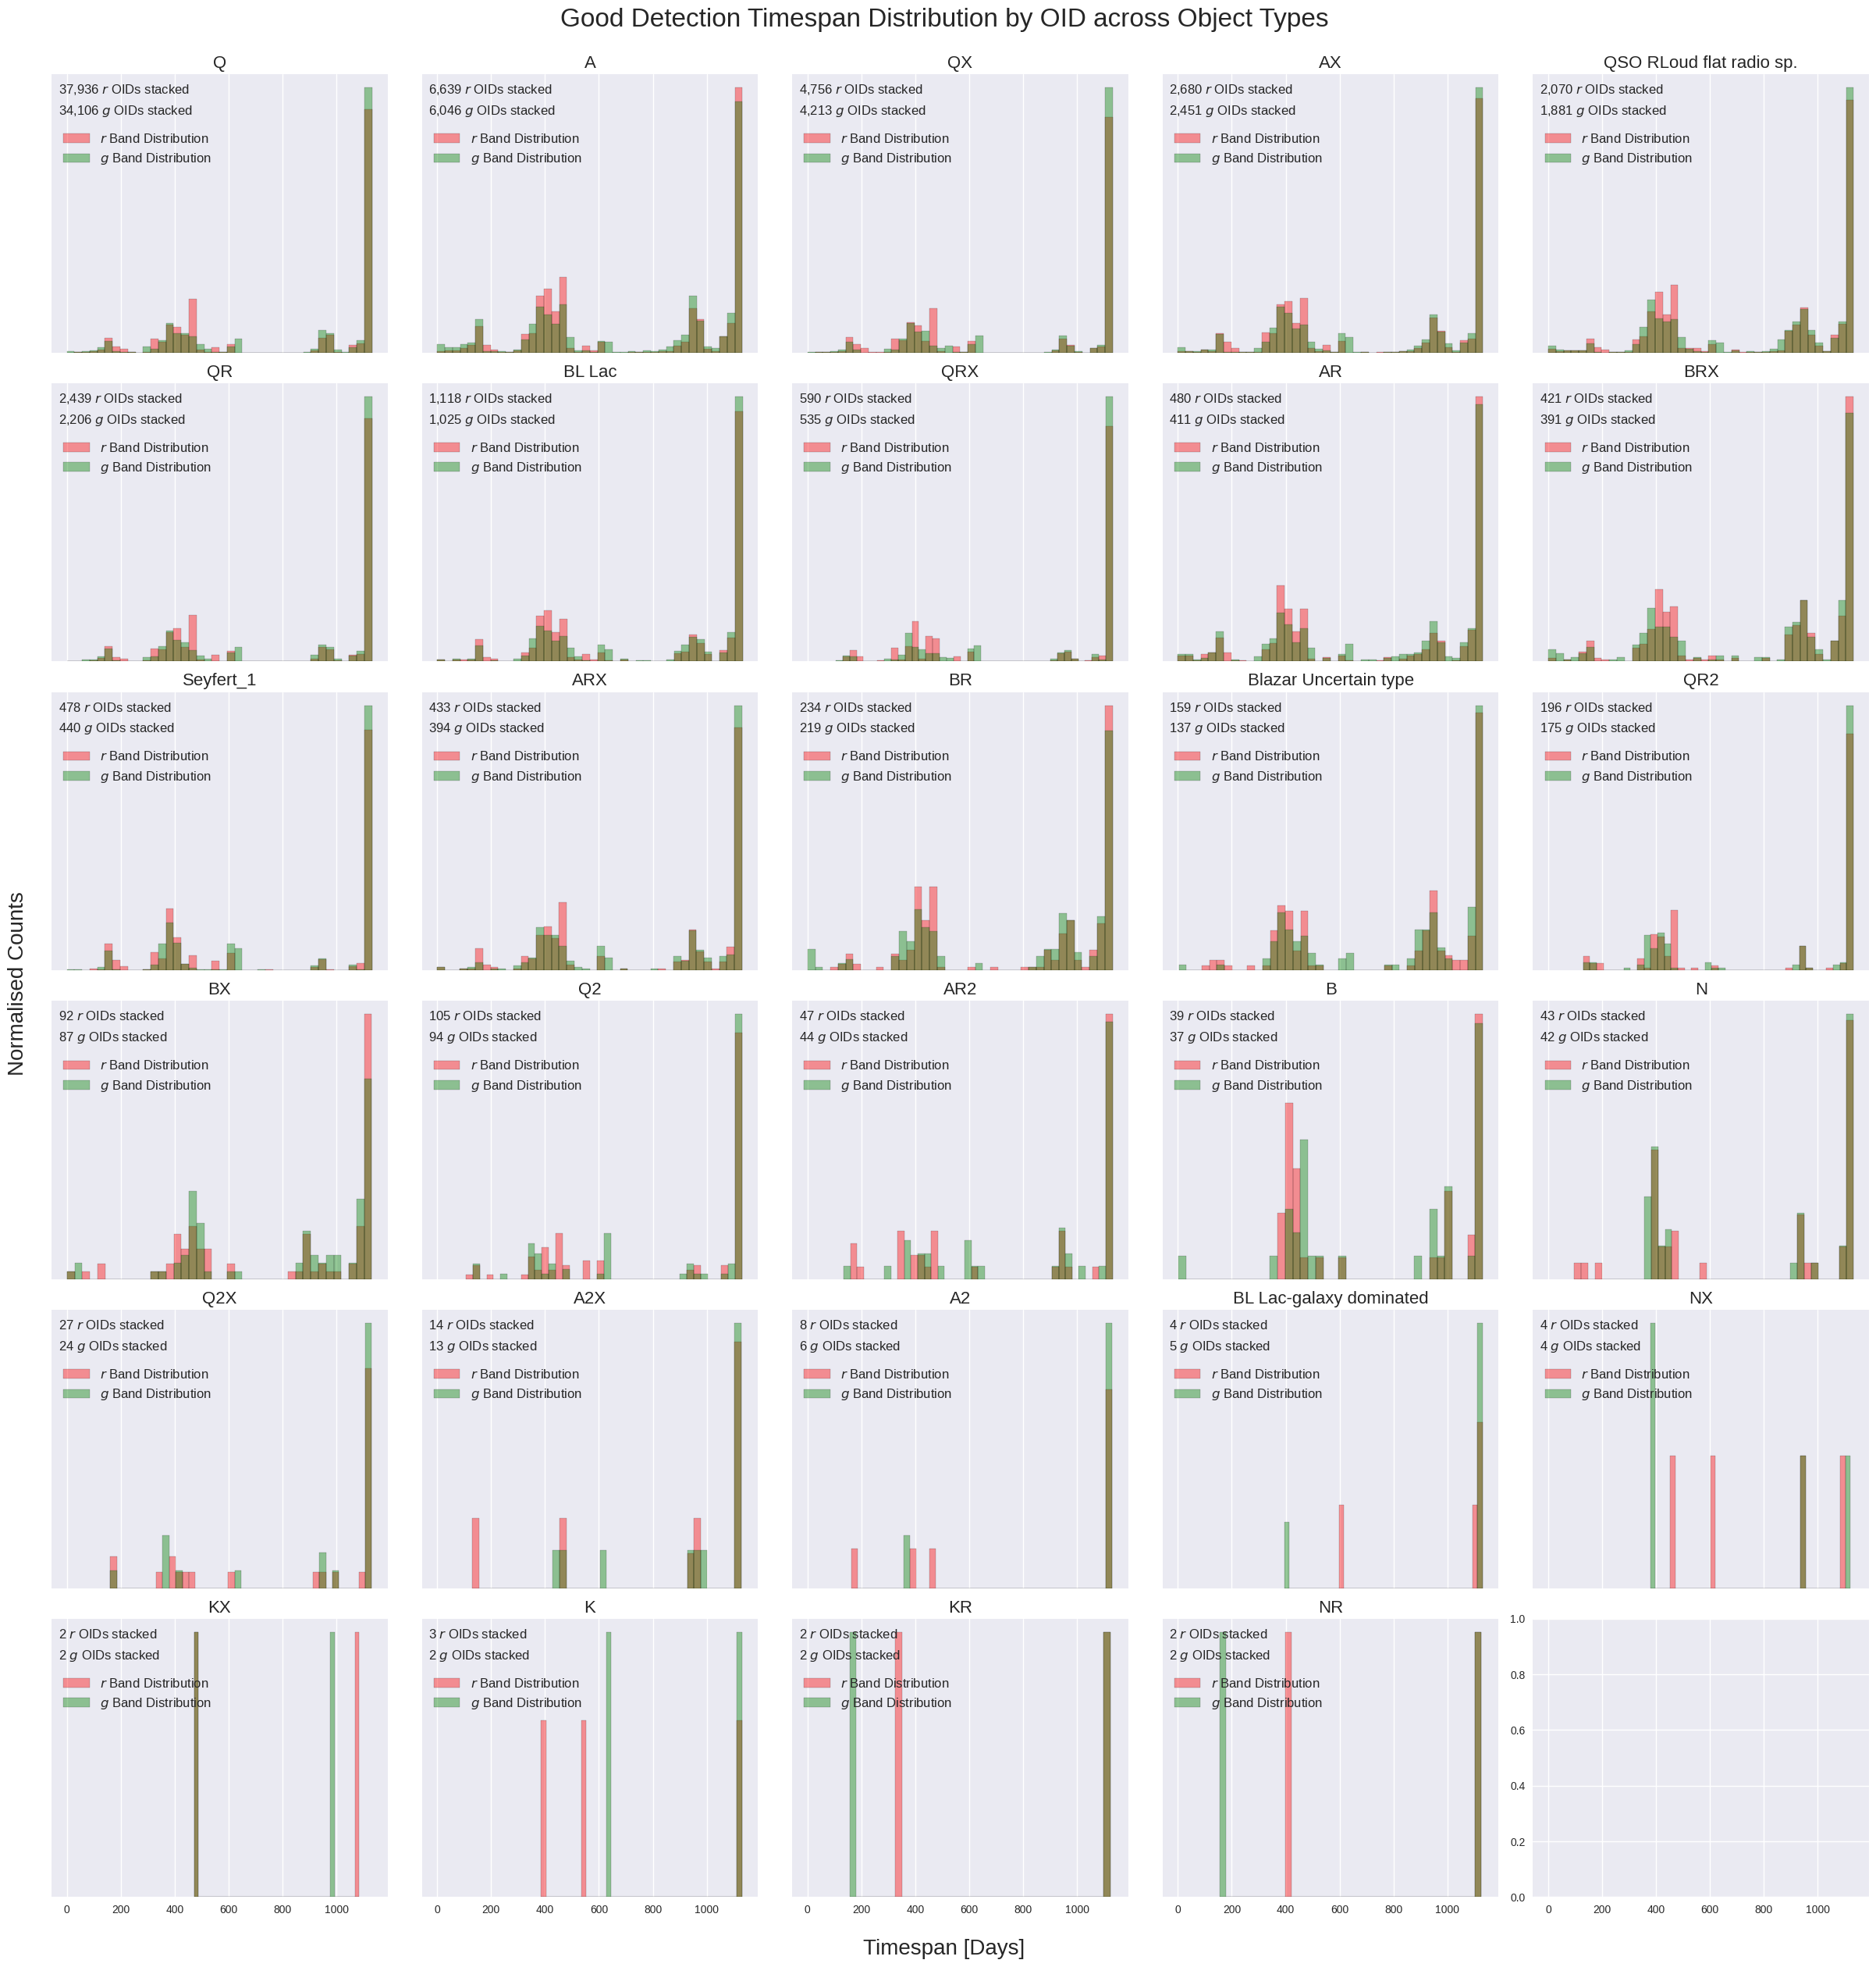

In [22]:
nrows, ncols = 6, 5
nbins = 40

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * nrows, 5 * ncols), sharex=True)

for ax, object_type in zip(axs.flatten(), object_types):
    df = lightcurves_by_oid.query("type == @object_type")

    r_timespan_good = df.query("band == 'r'").timespan_good
    g_timespan_good = df.query("band == 'g'").timespan_good     
    _, bins = np.histogram(r_timespan_good.to_list() + g_timespan_good.to_list(), bins=nbins, density=True)

    ax.hist(r_timespan_good, bins=bins, edgecolor='black', alpha=0.4, color='r', label='$r$ Band Distribution', density=True)
    ax.hist(g_timespan_good, bins=bins, edgecolor='black', alpha=0.4, color='g', label='$g$ Band Distribution', density=True)
    
    ax.text(x=0.02, y=0.93, s=f'{r_timespan_good.size:,} $r$ OIDs stacked', transform=ax.transAxes, fontsize=12)
    ax.text(x=0.02, y=0.855, s=f'{g_timespan_good.size:,} $g$ OIDs stacked', transform=ax.transAxes, fontsize=12)

    ax.yaxis.set_visible(False)
    ax.set_title(f'{object_type}', size=16)
    ax.legend(fontsize=12, loc=(0.02, 0.65))

fig.suptitle('Good Detection Timespan Distribution by OID across Object Types', size=24, y=1)
fig.supylabel('Normalised Counts', size=20, x=0)
fig.supxlabel('Timespan [Days]', size=20, y=0)

plt.tight_layout()
plt.show()

**Exploring the number of good detections in each lightcurve**

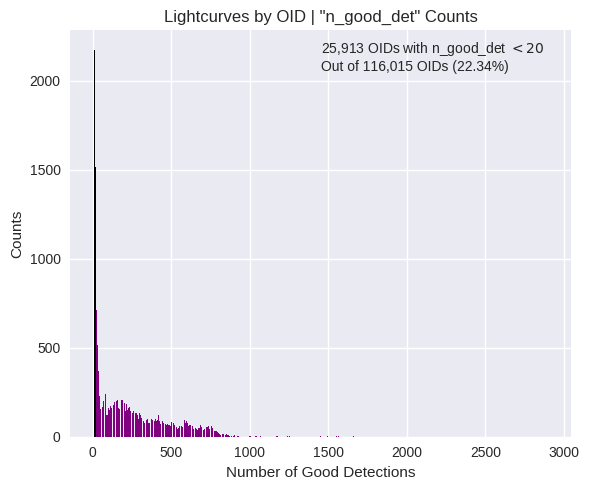

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

lightcurves_by_oid_value_counts = lightcurves_by_oid['n_good_det'].value_counts()

leq_than_20_counts = lightcurves_by_oid_value_counts[lightcurves_by_oid_value_counts.index < 20].sum()
all_counts = lightcurves_by_oid_value_counts.sum()

n_good_dets, counts = lightcurves_by_oid_value_counts.index, lightcurves_by_oid_value_counts.values
colors = ['black' if det < 20 else 'purple' for det in n_good_dets]

ax.bar(n_good_dets, counts, color=colors)
ax.text(0.5, 0.9, f'{leq_than_20_counts:,d} OIDs with n_good_det $< 20$\nOut of {all_counts:,d} OIDs ({leq_than_20_counts / all_counts:.2%})', transform=ax.transAxes)
ax.set_xlabel('Number of Good Detections')
ax.set_ylabel('Counts')
ax.set_title('Lightcurves by OID | "n_good_det" Counts')

plt.tight_layout()
plt.show()

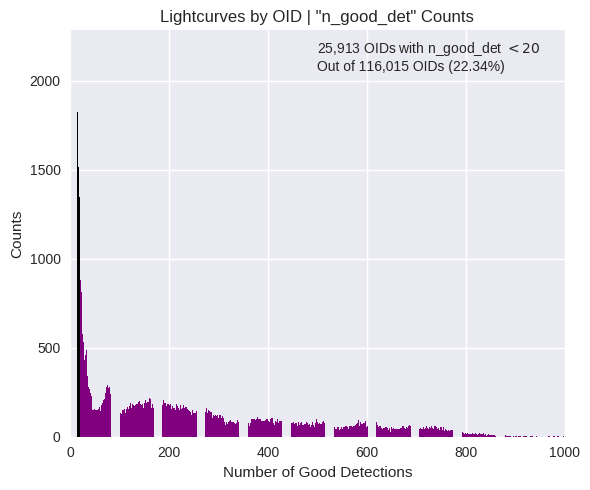

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

lightcurves_by_oid_value_counts = lightcurves_by_oid['n_good_det'].value_counts()

leq_than_20_counts = lightcurves_by_oid_value_counts[lightcurves_by_oid_value_counts.index < 20].sum()
all_counts = lightcurves_by_oid_value_counts.sum()

n_good_dets, counts = lightcurves_by_oid_value_counts.index, lightcurves_by_oid_value_counts.values
colors = ['black' if det < 20 else 'purple' for det in n_good_dets]

ax.bar(n_good_dets, counts, color=colors)
ax.text(0.5, 0.9, f'{leq_than_20_counts:,d} OIDs with n_good_det $< 20$\nOut of {all_counts:,d} OIDs ({leq_than_20_counts / all_counts:.2%})', transform=ax.transAxes)
ax.set_xlim(0, 1000)
ax.set_xlabel('Number of Good Detections')
ax.set_ylabel('Counts')
ax.set_title('Lightcurves by OID | "n_good_det" Counts')

plt.tight_layout()
plt.show()

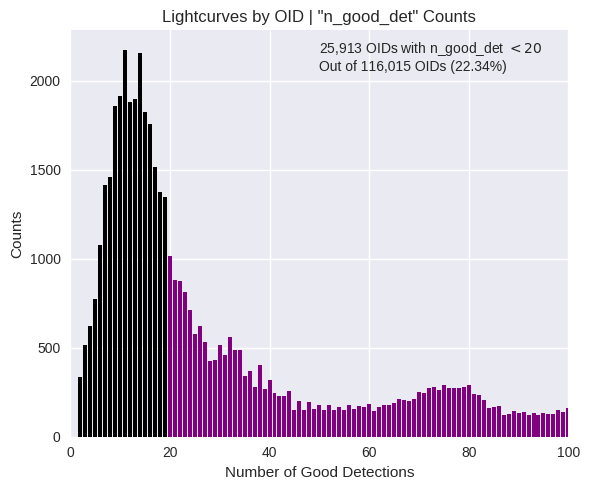

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

lightcurves_by_oid_value_counts = lightcurves_by_oid['n_good_det'].value_counts()

leq_than_20_counts = lightcurves_by_oid_value_counts[lightcurves_by_oid_value_counts.index < 20].sum()
all_counts = lightcurves_by_oid_value_counts.sum()

n_good_dets, counts = lightcurves_by_oid_value_counts.index, lightcurves_by_oid_value_counts.values
colors = ['black' if det < 20 else 'purple' for det in n_good_dets]

ax.bar(n_good_dets, counts, color=colors)
ax.text(0.5, 0.9, f'{leq_than_20_counts:,d} OIDs with n_good_det $< 20$\nOut of {all_counts:,d} OIDs ({leq_than_20_counts / all_counts:.2%})', transform=ax.transAxes)
ax.set_xlim(0, 100)
ax.set_xlabel('Number of Good Detections')
ax.set_ylabel('Counts')
ax.set_title('Lightcurves by OID | "n_good_det" Counts')

plt.tight_layout()
plt.show()

In [26]:
lightcurves_by_oid_QSOs = lightcurves_by_oid[lightcurves_by_oid['type'].isin(['Q', 'QR', 'QX'])]

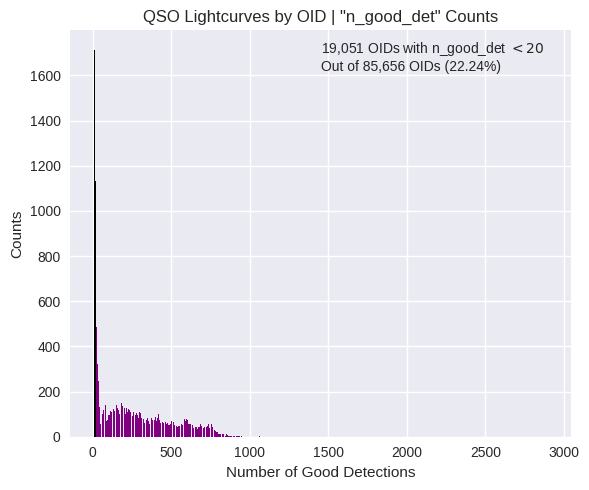

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

lightcurves_by_oid_value_counts = lightcurves_by_oid_QSOs['n_good_det'].value_counts()

leq_than_20_counts = lightcurves_by_oid_value_counts[lightcurves_by_oid_value_counts.index < 20].sum()
all_counts = lightcurves_by_oid_value_counts.sum()

n_good_dets, counts = lightcurves_by_oid_value_counts.index, lightcurves_by_oid_value_counts.values
colors = ['black' if det < 20 else 'purple' for det in n_good_dets]

ax.bar(n_good_dets, counts, color=colors)
ax.text(0.5, 0.9, f'{leq_than_20_counts:,d} OIDs with n_good_det $< 20$\nOut of {all_counts:,d} OIDs ({leq_than_20_counts / all_counts:.2%})', transform=ax.transAxes)
ax.set_title('QSO Lightcurves by OID | "n_good_det" Counts')
ax.set_xlabel('Number of Good Detections')
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

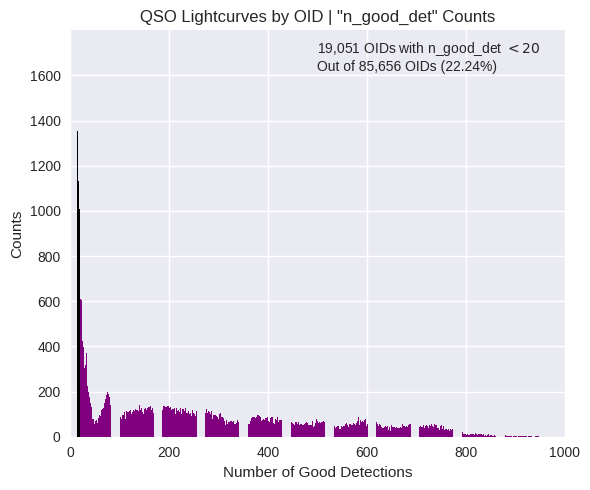

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

lightcurves_by_oid_value_counts = lightcurves_by_oid_QSOs['n_good_det'].value_counts()

leq_than_20_counts = lightcurves_by_oid_value_counts[lightcurves_by_oid_value_counts.index < 20].sum()
all_counts = lightcurves_by_oid_value_counts.sum()

n_good_dets, counts = lightcurves_by_oid_value_counts.index, lightcurves_by_oid_value_counts.values
colors = ['black' if det < 20 else 'purple' for det in n_good_dets]

ax.bar(n_good_dets, counts, color=colors)
ax.text(0.5, 0.9, f'{leq_than_20_counts:,d} OIDs with n_good_det $< 20$\nOut of {all_counts:,d} OIDs ({leq_than_20_counts / all_counts:.2%})', transform=ax.transAxes)
ax.set_xlim(0, 1000)
ax.set_xlabel('Number of Good Detections')
ax.set_ylabel('Counts')
ax.set_title('QSO Lightcurves by OID | "n_good_det" Counts')

plt.tight_layout()
plt.show()

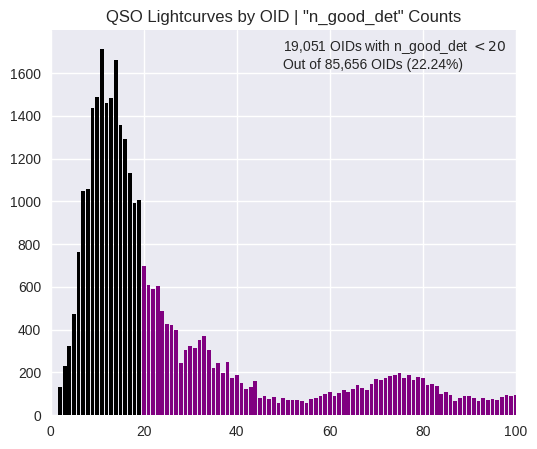

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

lightcurves_by_oid_value_counts = lightcurves_by_oid_QSOs['n_good_det'].value_counts()

leq_than_20_counts = lightcurves_by_oid_value_counts[lightcurves_by_oid_value_counts.index < 20].sum()
all_counts = lightcurves_by_oid_value_counts.sum()

n_good_dets, counts = lightcurves_by_oid_value_counts.index, lightcurves_by_oid_value_counts.values
colors = ['black' if det < 20 else 'purple' for det in n_good_dets]

ax.bar(n_good_dets, counts, color=colors)
ax.text(0.5, 0.9, f'{leq_than_20_counts:,d} OIDs with n_good_det $< 20$\nOut of {all_counts:,d} OIDs ({leq_than_20_counts / all_counts:.2%})', transform=ax.transAxes)
ax.set_xlim(0, 100)
ax.set_title('QSO Lightcurves by OID | "n_good_det" Counts')

plt.show()

#### Saving Lightcurves by Object

In [30]:
name_grouped = lightcurves.groupby(by='name', observed=True)
lightcurves_by_object_dict_list = []

for name, name_df in tqdm(name_grouped):
    lightcurves_by_object_dict = {'name': name, 'type': name_df.type.iloc[0], 'ra': name_df.ra.mean(), 'dec': name_df.dec.mean(), 'z': name_df.z.mean()}

    name_band_grouped = name_df.groupby(by='band', observed=True)
    for band, name_band_df in name_band_grouped:
        if len(name_band_df) < 2:
            continue
        name_band_df = name_band_df.sort_values(by='mjd')
        mjds, mags, magerrs = name_band_df['mjd'].to_numpy(), name_band_df['mag'].to_numpy(), name_band_df['magerr'].to_numpy()

        lightcurves_by_object_dict[f'{band}_timespan_good'] = mjds.max() - mjds.min()
        lightcurves_by_object_dict[f'{band}_n_good_det'] = mjds.size
        lightcurves_by_object_dict[f'{band}_oids'] = name_band_df.oid_alerce.to_numpy()
        lightcurves_by_object_dict[f'{band}_lightcurve'] = np.column_stack([mjds, mags, magerrs])
        
    lightcurves_by_object_dict_list.append(lightcurves_by_object_dict)

  0%|          | 0/32231 [00:00<?, ?it/s]

In [31]:
lightcurves_by_object = pd.DataFrame(lightcurves_by_object_dict_list)
lightcurves_by_object_dict_list = np.nan
lightcurves_by_object

,name,type,ra,dec,z,g_timespan_good,g_n_good_det,g_oids,g_lightcurve,r_timespan_good,r_n_good_det,r_oids,r_lightcurve
0,1AXG J000605+2031,AX,1.497482,20.523582,0.380,964.688067,229.0,"[550110200005509, 550110200005509, 55011020000...","[[58268.4661921, 17.2914085, 0.0193178076], [5...",981.708229,222.0,"[550210200011033, 550210200011033, 55021020001...","[[58268.4470486, 17.2935829, 0.0198369212], [5..."
1,1AXG J035008-1149,AX,57.522460,-11.824012,0.450,376.989526,10.0,"[1344109100000968, 1345112200001061, 134410910...","[[58390.4113657, 19.8996181, 0.129595727], [58...",340.960799,6.0,"[1344209100007817, 1344209100007817, 134521220...","[[58432.3809954, 19.886844600000003, 0.1277610..."
2,1AXG J102337+1936,AX,155.906410,19.607236,0.400,1125.946574,302.0,"[1617102300000313, 572112300000950, 5721123000...","[[58202.2667708, 19.302185100000003, 0.0567675...",1111.032025,372.0,"[571209400025315, 572212300012759, 57120940002...","[[58217.2006713, 19.074201600000002, 0.0849977..."
3,1AXG J103934+5330,AX,159.899004,53.510771,0.220,1125.941366,596.0,"[787106300012098, 787106300012098, 78710630001...","[[58202.278287, 18.849639899999996, 0.07062309...",1110.976366,1094.0,"[787206300003755, 787206300003755, 78720630000...","[[58217.208044, 18.4565163, 0.0527343191], [58..."
4,1AXG J141240-1209,ARX,213.163559,-12.152564,0.240,1124.960092,97.0,"[374101100002157, 374101100002157, 37410110000...","[[58203.3556019, 18.353233300000003, 0.0372927...",1110.925174,125.0,"[374201100002922, 374201100002922, 37420110000...","[[58217.3477083, 17.7982368, 0.03306688], [582..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32226,[MML2015] 5BZU J2303-1841,Blazar Uncertain type,345.762389,-18.690489,0.129,943.647153,113.0,"[343107300003455, 343107300003455, 34310730000...","[[58271.4817361, 17.5503979, 0.0294231866], [5...",934.600636,122.0,"[343207300022649, 343207300022649, 34320730002...","[[58280.4806019, 17.1972923, 0.021261705099999..."
32227,[MML2015] 5BZU J2352+3947,Blazar Uncertain type,358.203798,39.798961,0.858,880.858472,126.0,"[735105200025684, 735105200025684, 73510520002...","[[58263.4649421, 21.2750149, 0.199958682], [58...",1055.069306,274.0,"[735205200008210, 735205200008210, 73520520000...","[[58273.4300694, 20.5700836, 0.156238914], [58..."
32228,[MML2015] 5BZU J2354-0405,Blazar Uncertain type,358.715322,-4.084275,0.720,949.702442,143.0,"[396108300002183, 396108300002183, 39610830000...","[[58280.4460301, 18.0638905, 0.0327166282], [5...",955.627373,160.0,"[396208300004495, 396208300004495, 39620830000...","[[58274.4822801, 17.906671499999998, 0.0324850..."
32229,eHAQ0142+0257,QR,25.528603,2.953628,2.310,957.648796,214.0,"[450107400003174, 450107400003174, 45010740000...","[[58298.4827431, 18.9552612, 0.063075698899999...",962.719190,342.0,"[450207400009426, 450207400009426, 45020740000...","[[58301.4430787, 17.906868, 0.0333674327], [58..."


In [32]:
lightcurves_by_object.isna().sum()

name                 0
type                 0
ra                   0
dec                  0
z                  616
g_timespan_good    303
g_n_good_det       303
g_oids             303
g_lightcurve       303
r_timespan_good    107
r_n_good_det       107
r_oids             107
r_lightcurve       107
dtype: int64

In [33]:
lightcurves_by_object.to_pickle(filtered_lightcurves_by_name_pkl)
# lightcurves_by_object = pd.read_pickle(filtered_lightcurves_by_name_pkl)

lightcurves_by_object

,name,type,ra,dec,z,g_timespan_good,g_n_good_det,g_oids,g_lightcurve,r_timespan_good,r_n_good_det,r_oids,r_lightcurve
0,1AXG J000605+2031,AX,1.497482,20.523582,0.380,964.688067,229.0,"[550110200005509, 550110200005509, 55011020000...","[[58268.4661921, 17.2914085, 0.0193178076], [5...",981.708229,222.0,"[550210200011033, 550210200011033, 55021020001...","[[58268.4470486, 17.2935829, 0.0198369212], [5..."
1,1AXG J035008-1149,AX,57.522460,-11.824012,0.450,376.989526,10.0,"[1344109100000968, 1345112200001061, 134410910...","[[58390.4113657, 19.8996181, 0.129595727], [58...",340.960799,6.0,"[1344209100007817, 1344209100007817, 134521220...","[[58432.3809954, 19.886844600000003, 0.1277610..."
2,1AXG J102337+1936,AX,155.906410,19.607236,0.400,1125.946574,302.0,"[1617102300000313, 572112300000950, 5721123000...","[[58202.2667708, 19.302185100000003, 0.0567675...",1111.032025,372.0,"[571209400025315, 572212300012759, 57120940002...","[[58217.2006713, 19.074201600000002, 0.0849977..."
3,1AXG J103934+5330,AX,159.899004,53.510771,0.220,1125.941366,596.0,"[787106300012098, 787106300012098, 78710630001...","[[58202.278287, 18.849639899999996, 0.07062309...",1110.976366,1094.0,"[787206300003755, 787206300003755, 78720630000...","[[58217.208044, 18.4565163, 0.0527343191], [58..."
4,1AXG J141240-1209,ARX,213.163559,-12.152564,0.240,1124.960092,97.0,"[374101100002157, 374101100002157, 37410110000...","[[58203.3556019, 18.353233300000003, 0.0372927...",1110.925174,125.0,"[374201100002922, 374201100002922, 37420110000...","[[58217.3477083, 17.7982368, 0.03306688], [582..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32226,[MML2015] 5BZU J2303-1841,Blazar Uncertain type,345.762389,-18.690489,0.129,943.647153,113.0,"[343107300003455, 343107300003455, 34310730000...","[[58271.4817361, 17.5503979, 0.0294231866], [5...",934.600636,122.0,"[343207300022649, 343207300022649, 34320730002...","[[58280.4806019, 17.1972923, 0.021261705099999..."
32227,[MML2015] 5BZU J2352+3947,Blazar Uncertain type,358.203798,39.798961,0.858,880.858472,126.0,"[735105200025684, 735105200025684, 73510520002...","[[58263.4649421, 21.2750149, 0.199958682], [58...",1055.069306,274.0,"[735205200008210, 735205200008210, 73520520000...","[[58273.4300694, 20.5700836, 0.156238914], [58..."
32228,[MML2015] 5BZU J2354-0405,Blazar Uncertain type,358.715322,-4.084275,0.720,949.702442,143.0,"[396108300002183, 396108300002183, 39610830000...","[[58280.4460301, 18.0638905, 0.0327166282], [5...",955.627373,160.0,"[396208300004495, 396208300004495, 39620830000...","[[58274.4822801, 17.906671499999998, 0.0324850..."
32229,eHAQ0142+0257,QR,25.528603,2.953628,2.310,957.648796,214.0,"[450107400003174, 450107400003174, 45010740000...","[[58298.4827431, 18.9552612, 0.063075698899999...",962.719190,342.0,"[450207400009426, 450207400009426, 45020740000...","[[58301.4430787, 17.906868, 0.0333674327], [58..."


In [34]:
print(f'There are a total of {len(lightcurves_by_object):,} objects with a lightcurve in at least one band.')

There are a total of 32,231 objects with a lightcurve in at least one band.


In [35]:
# lightcurves_by_object = np.nan

**timespan_good distribution**

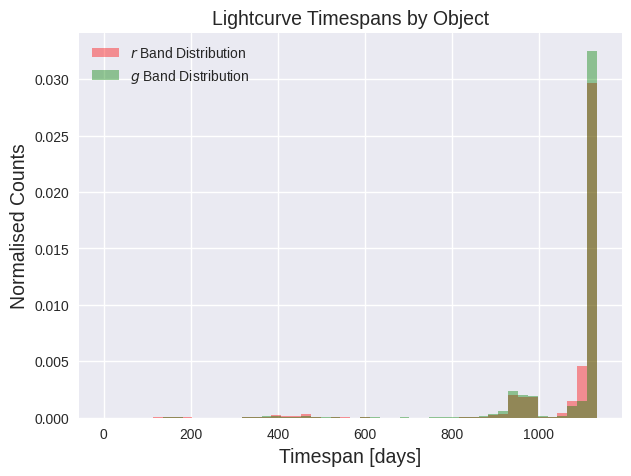

In [36]:
nbins = 50
hist_log = False

r_timespan_good = lightcurves_by_object.r_timespan_good.dropna()
g_timespan_good = lightcurves_by_object.g_timespan_good.dropna()

_, bins = np.histogram(r_timespan_good.to_list() + g_timespan_good.to_list(), bins=nbins, density=True)

plt.figure(figsize=(7, 5))

plt.hist(r_timespan_good, bins=bins, alpha=0.4, color='r', label='$r$ Band Distribution', density=True, log=hist_log)
plt.hist(g_timespan_good, bins=bins, alpha=0.4, color='g', label='$g$ Band Distribution', density=True, log=hist_log)

# plt.yscale('log')
# plt.xticks(bin_centers, labels=categories, rotation=0, size=9)
plt.title('Lightcurve Timespans by Object', size=14)
plt.xlabel('Timespan [days]', size=14)
plt.ylabel('Normalised Counts', size=14)
plt.legend()
plt.show()

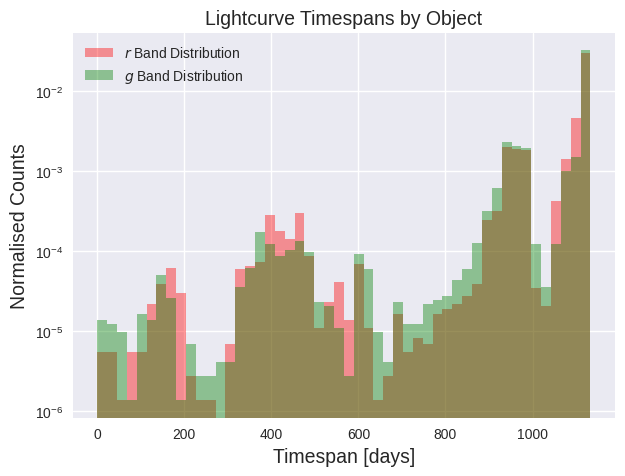

In [37]:
nbins = 50
hist_log = True

r_timespan_good = lightcurves_by_object.r_timespan_good.dropna()
g_timespan_good = lightcurves_by_object.g_timespan_good.dropna()

_, bins = np.histogram(r_timespan_good.to_list() + g_timespan_good.to_list(), bins=nbins, density=True)

plt.figure(figsize=(7, 5))

plt.hist(r_timespan_good, bins=bins, alpha=0.4, color='r', label='$r$ Band Distribution', density=True, log=hist_log)
plt.hist(g_timespan_good, bins=bins, alpha=0.4, color='g', label='$g$ Band Distribution', density=True, log=hist_log)

# plt.yscale('log')
# plt.xticks(bin_centers, labels=categories, rotation=0, size=9)
plt.title('Lightcurve Timespans by Object', size=14)
plt.xlabel('Timespan [days]', size=14)
plt.ylabel('Normalised Counts', size=14)
plt.legend()
plt.show()

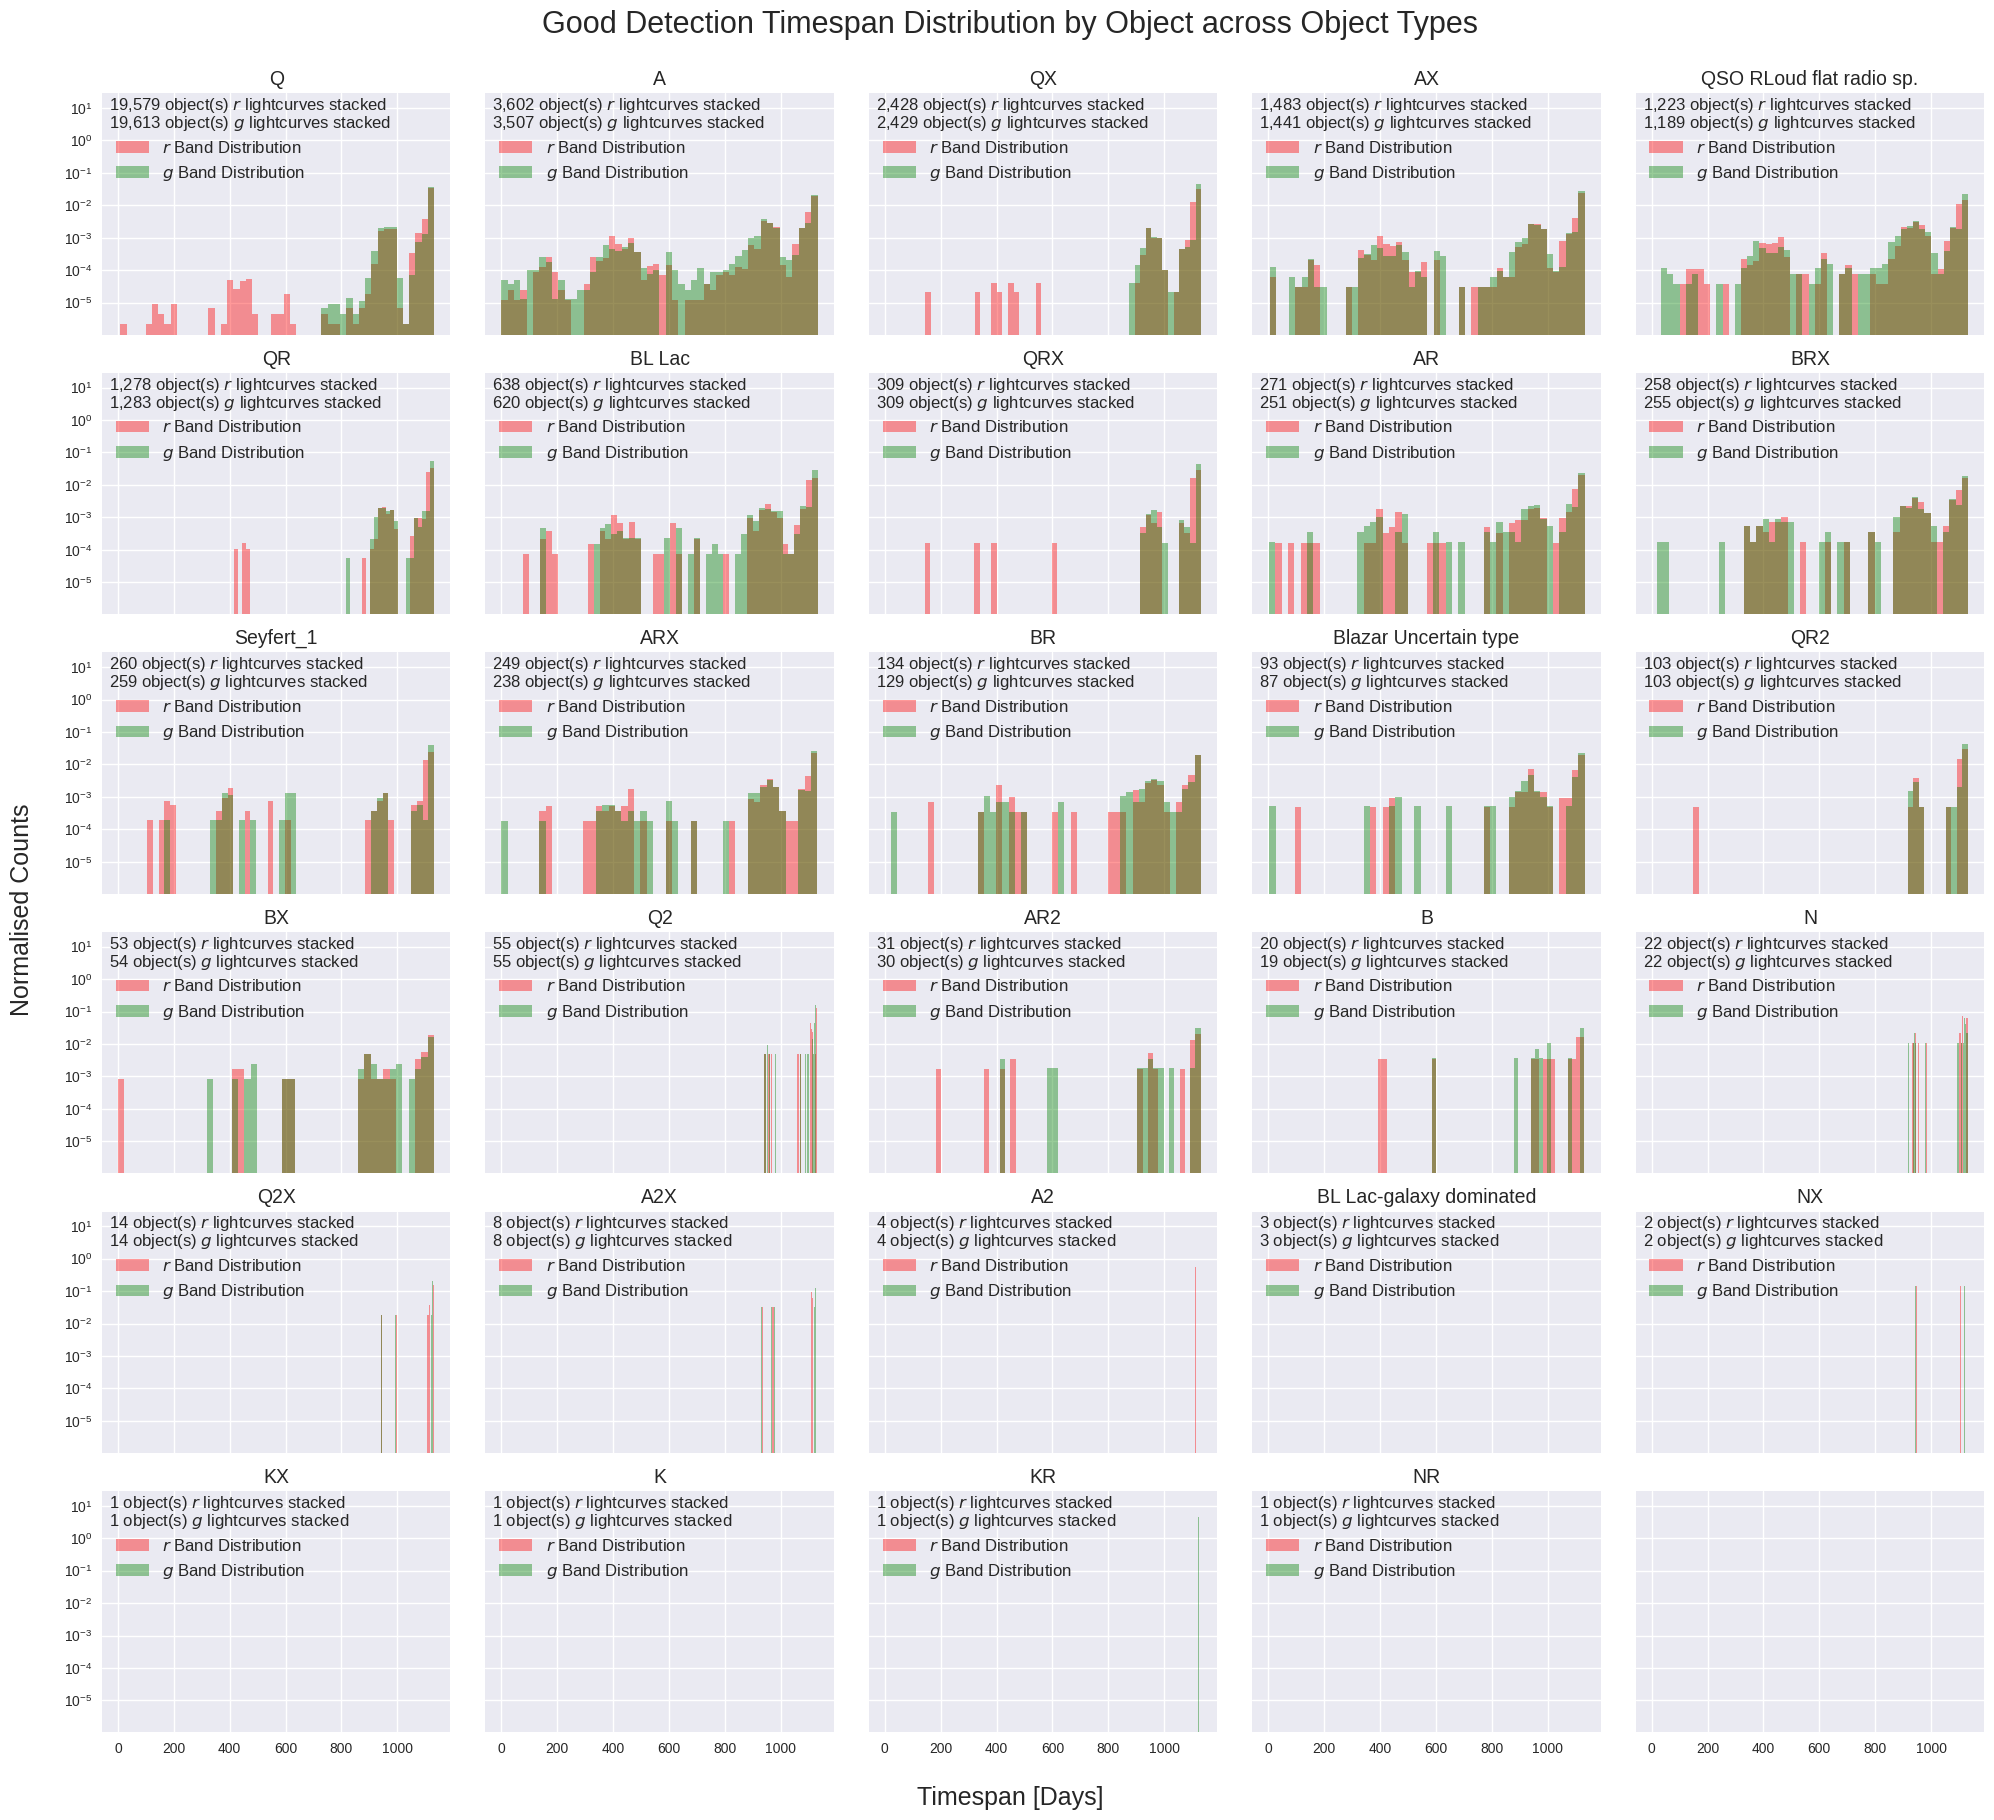

In [38]:
nrows, ncols = 6, 5
nbins = 50
hist_log = True

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows), sharex=True, sharey=True)

for ax, object_type in zip(axs.flatten(), object_types):
    df = lightcurves_by_object.query("type == @object_type")

    r_timespan_good = df.r_timespan_good.dropna()
    g_timespan_good = df.g_timespan_good.dropna()
    _, bins = np.histogram(r_timespan_good.to_list() + g_timespan_good.to_list(), bins=nbins, density=True)

    ax.hist(r_timespan_good, bins=bins, alpha=0.4, color='r', label='$r$ Band Distribution', density=True, log=hist_log)
    ax.hist(g_timespan_good, bins=bins, alpha=0.4, color='g', label='$g$ Band Distribution', density=True, log=hist_log)
    
    ax.text(x=0.02, y=0.93, s=f'{r_timespan_good.size:,} object(s) $r$ lightcurves stacked', transform=ax.transAxes, fontsize=12)
    ax.text(x=0.02, y=0.855, s=f'{g_timespan_good.size:,} object(s) $g$ lightcurves stacked', transform=ax.transAxes, fontsize=12)
    
    ax.set_title(f'{object_type}', size=14)
    ax.legend(fontsize=12, loc=(0.02, 0.6))

fig.suptitle('Good Detection Timespan Distribution by Object across Object Types', size=22, y=1)
fig.supylabel('Normalised Counts', size=18, x=0)
fig.supxlabel('Timespan [Days]', size=18, y=0)

plt.tight_layout()
plt.show()

**n_good_det distributions**

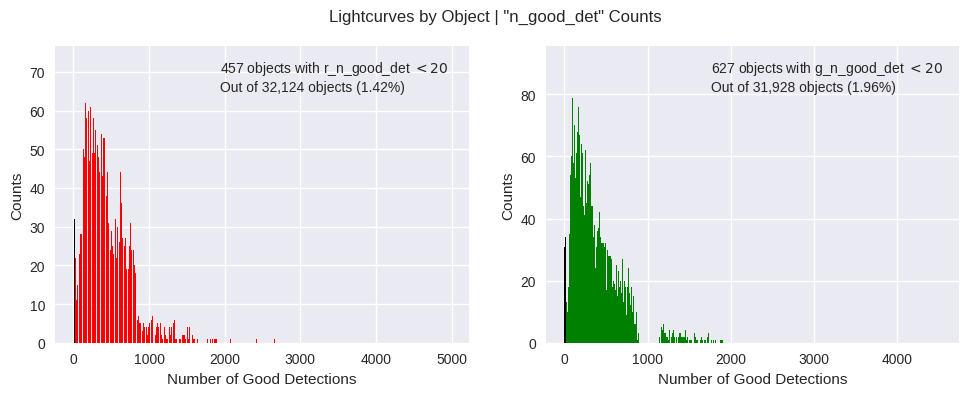

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 5, 4))

r_lightcurves_by_object_value_counts = lightcurves_by_object['r_n_good_det'].value_counts()

r_leq_than_20_counts = r_lightcurves_by_object_value_counts[r_lightcurves_by_object_value_counts.index < 20].sum()
r_all_counts = r_lightcurves_by_object_value_counts.sum()

r_n_good_dets, r_counts = r_lightcurves_by_object_value_counts.index, r_lightcurves_by_object_value_counts.values
r_colors = ['black' if det < 20 else 'red' for det in r_n_good_dets]


g_lightcurves_by_object_value_counts = lightcurves_by_object['g_n_good_det'].value_counts()

g_leq_than_20_counts = g_lightcurves_by_object_value_counts[g_lightcurves_by_object_value_counts.index < 20].sum()
g_all_counts = g_lightcurves_by_object_value_counts.sum()

g_n_good_dets, g_counts = g_lightcurves_by_object_value_counts.index, g_lightcurves_by_object_value_counts.values
g_colors = ['black' if det < 20 else 'green' for det in g_n_good_dets]

axs[0].bar(r_n_good_dets, r_counts, color=r_colors)
axs[0].text(0.4, 0.85, f'{r_leq_than_20_counts:,d} objects with r_n_good_det $< 20$\nOut of {r_all_counts:,d} objects ({r_leq_than_20_counts / r_all_counts:.2%})', transform=axs[0].transAxes)
# axs[0].set_xlim(0, 1000)
axs[0].set_xlabel('Number of Good Detections')
axs[0].set_ylabel('Counts')

axs[1].bar(g_n_good_dets, g_counts, color=g_colors)
axs[1].text(0.4, 0.85, f'{g_leq_than_20_counts:,d} objects with g_n_good_det $< 20$\nOut of {g_all_counts:,d} objects ({g_leq_than_20_counts / g_all_counts:.2%})', transform=axs[1].transAxes)
# axs[1].set_xlim(0, 1000)
axs[1].set_xlabel('Number of Good Detections')
axs[1].set_ylabel('Counts')

fig.suptitle('Lightcurves by Object | "n_good_det" Counts', )

plt.tight_layout()
plt.show()

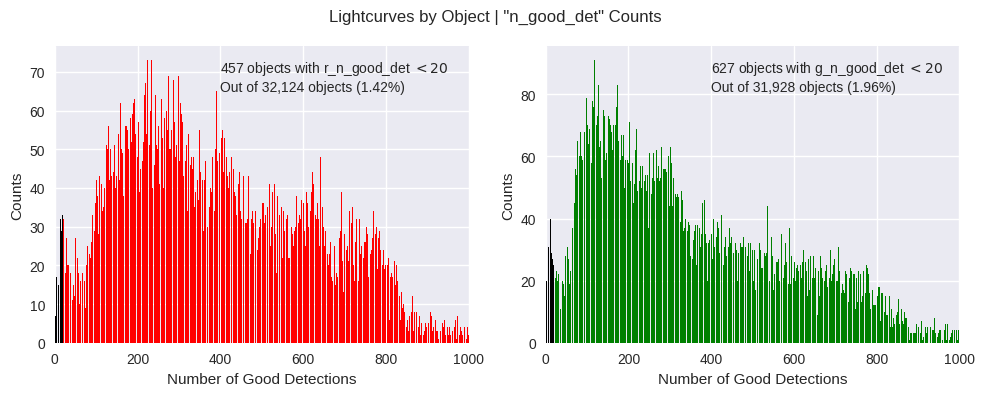

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 5, 4))

r_lightcurves_by_object_value_counts = lightcurves_by_object['r_n_good_det'].value_counts()

r_leq_than_20_counts = r_lightcurves_by_object_value_counts[r_lightcurves_by_object_value_counts.index < 20].sum()
r_all_counts = r_lightcurves_by_object_value_counts.sum()

r_n_good_dets, r_counts = r_lightcurves_by_object_value_counts.index, r_lightcurves_by_object_value_counts.values
r_colors = ['black' if det < 20 else 'red' for det in r_n_good_dets]


g_lightcurves_by_object_value_counts = lightcurves_by_object['g_n_good_det'].value_counts()

g_leq_than_20_counts = g_lightcurves_by_object_value_counts[g_lightcurves_by_object_value_counts.index < 20].sum()
g_all_counts = g_lightcurves_by_object_value_counts.sum()

g_n_good_dets, g_counts = g_lightcurves_by_object_value_counts.index, g_lightcurves_by_object_value_counts.values
g_colors = ['black' if det < 20 else 'green' for det in g_n_good_dets]

axs[0].bar(r_n_good_dets, r_counts, color=r_colors)
axs[0].text(0.4, 0.85, f'{r_leq_than_20_counts:,d} objects with r_n_good_det $< 20$\nOut of {r_all_counts:,d} objects ({r_leq_than_20_counts / r_all_counts:.2%})', transform=axs[0].transAxes)
axs[0].set_xlim(0, 1000)
axs[0].set_xlabel('Number of Good Detections')
axs[0].set_ylabel('Counts')

axs[1].bar(g_n_good_dets, g_counts, color=g_colors)
axs[1].text(0.4, 0.85, f'{g_leq_than_20_counts:,d} objects with g_n_good_det $< 20$\nOut of {g_all_counts:,d} objects ({g_leq_than_20_counts / g_all_counts:.2%})', transform=axs[1].transAxes)
axs[1].set_xlim(0, 1000)
axs[1].set_xlabel('Number of Good Detections')
axs[1].set_ylabel('Counts')

fig.suptitle('Lightcurves by Object | "n_good_det" Counts', )

plt.tight_layout()
plt.show()

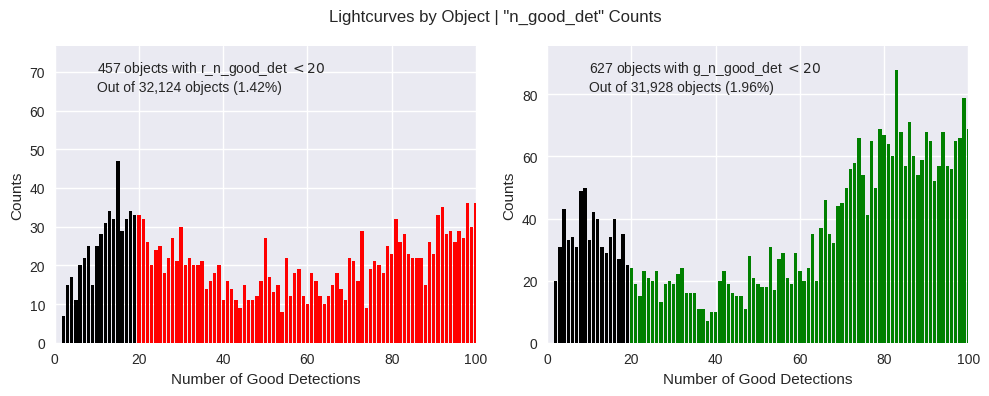

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 5, 4))

r_lightcurves_by_object_value_counts = lightcurves_by_object['r_n_good_det'].value_counts()

r_leq_than_20_counts = r_lightcurves_by_object_value_counts[r_lightcurves_by_object_value_counts.index < 20].sum()
r_all_counts = r_lightcurves_by_object_value_counts.sum()

r_n_good_dets, r_counts = r_lightcurves_by_object_value_counts.index, r_lightcurves_by_object_value_counts.values
r_colors = ['black' if det < 20 else 'red' for det in r_n_good_dets]


g_lightcurves_by_object_value_counts = lightcurves_by_object['g_n_good_det'].value_counts()

g_leq_than_20_counts = g_lightcurves_by_object_value_counts[g_lightcurves_by_object_value_counts.index < 20].sum()
g_all_counts = g_lightcurves_by_object_value_counts.sum()

g_n_good_dets, g_counts = g_lightcurves_by_object_value_counts.index, g_lightcurves_by_object_value_counts.values
g_colors = ['black' if det < 20 else 'green' for det in g_n_good_dets]

axs[0].bar(r_n_good_dets, r_counts, color=r_colors)
axs[0].text(0.1, 0.85, f'{r_leq_than_20_counts:,d} objects with r_n_good_det $< 20$\nOut of {r_all_counts:,d} objects ({r_leq_than_20_counts / r_all_counts:.2%})', transform=axs[0].transAxes)
axs[0].set_xlim(0, 100)
axs[0].set_xlabel('Number of Good Detections')
axs[0].set_ylabel('Counts')

axs[1].bar(g_n_good_dets, g_counts, color=g_colors)
axs[1].text(0.1, 0.85, f'{g_leq_than_20_counts:,d} objects with g_n_good_det $< 20$\nOut of {g_all_counts:,d} objects ({g_leq_than_20_counts / g_all_counts:.2%})', transform=axs[1].transAxes)
axs[1].set_xlim(0, 100)
axs[1].set_xlabel('Number of Good Detections')
axs[1].set_ylabel('Counts')

fig.suptitle('Lightcurves by Object | "n_good_det" Counts', )

plt.tight_layout()
plt.show()

In [42]:
lightcurves_by_object_QSOs = lightcurves_by_object[lightcurves_by_object['type'].isin(['Q', 'QR', 'QX'])]

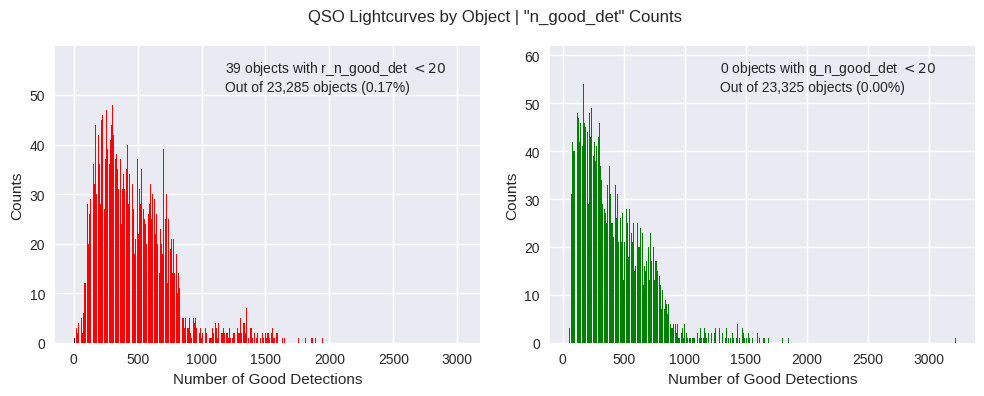

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 5, 4))

r_lightcurves_by_object_value_counts = lightcurves_by_object_QSOs['r_n_good_det'].value_counts()

r_leq_than_20_counts = r_lightcurves_by_object_value_counts[r_lightcurves_by_object_value_counts.index < 20].sum()
r_all_counts = r_lightcurves_by_object_value_counts.sum()

r_n_good_dets, r_counts = r_lightcurves_by_object_value_counts.index, r_lightcurves_by_object_value_counts.values
r_colors = ['black' if det < 20 else 'red' for det in r_n_good_dets]


g_lightcurves_by_object_value_counts = lightcurves_by_object_QSOs['g_n_good_det'].value_counts()

g_leq_than_20_counts = g_lightcurves_by_object_value_counts[g_lightcurves_by_object_value_counts.index < 20].sum()
g_all_counts = g_lightcurves_by_object_value_counts.sum()

g_n_good_dets, g_counts = g_lightcurves_by_object_value_counts.index, g_lightcurves_by_object_value_counts.values
g_colors = ['black' if det < 20 else 'green' for det in g_n_good_dets]

axs[0].bar(r_n_good_dets, r_counts, color=r_colors)
axs[0].text(0.4, 0.85, f'{r_leq_than_20_counts:,d} objects with r_n_good_det $< 20$\nOut of {r_all_counts:,d} objects ({r_leq_than_20_counts / r_all_counts:.2%})', transform=axs[0].transAxes)
# axs[0].set_xlim(0, 1000)
axs[0].set_xlabel('Number of Good Detections')
axs[0].set_ylabel('Counts')

axs[1].bar(g_n_good_dets, g_counts, color=g_colors)
axs[1].text(0.4, 0.85, f'{g_leq_than_20_counts:,d} objects with g_n_good_det $< 20$\nOut of {g_all_counts:,d} objects ({g_leq_than_20_counts / g_all_counts:.2%})', transform=axs[1].transAxes)
# axs[1].set_xlim(0, 1000)
axs[1].set_xlabel('Number of Good Detections')
axs[1].set_ylabel('Counts')

fig.suptitle('QSO Lightcurves by Object | "n_good_det" Counts', )

plt.tight_layout()
plt.show()

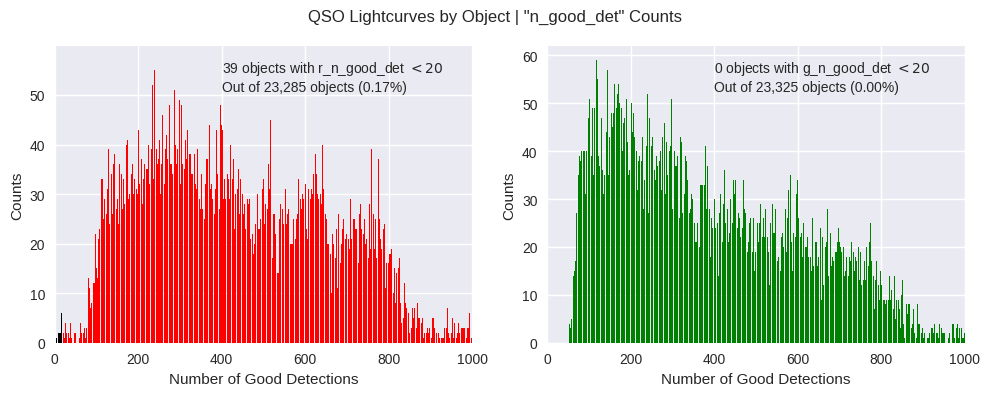

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 5, 4))

r_lightcurves_by_object_value_counts = lightcurves_by_object_QSOs['r_n_good_det'].value_counts()

r_leq_than_20_counts = r_lightcurves_by_object_value_counts[r_lightcurves_by_object_value_counts.index < 20].sum()
r_all_counts = r_lightcurves_by_object_value_counts.sum()

r_n_good_dets, r_counts = r_lightcurves_by_object_value_counts.index, r_lightcurves_by_object_value_counts.values
r_colors = ['black' if det < 20 else 'red' for det in r_n_good_dets]


g_lightcurves_by_object_value_counts = lightcurves_by_object_QSOs['g_n_good_det'].value_counts()

g_leq_than_20_counts = g_lightcurves_by_object_value_counts[g_lightcurves_by_object_value_counts.index < 20].sum()
g_all_counts = g_lightcurves_by_object_value_counts.sum()

g_n_good_dets, g_counts = g_lightcurves_by_object_value_counts.index, g_lightcurves_by_object_value_counts.values
g_colors = ['black' if det < 20 else 'green' for det in g_n_good_dets]

axs[0].bar(r_n_good_dets, r_counts, color=r_colors)
axs[0].text(0.4, 0.85, f'{r_leq_than_20_counts:,d} objects with r_n_good_det $< 20$\nOut of {r_all_counts:,d} objects ({r_leq_than_20_counts / r_all_counts:.2%})', transform=axs[0].transAxes)
axs[0].set_xlim(0, 1000)
axs[0].set_xlabel('Number of Good Detections')
axs[0].set_ylabel('Counts')

axs[1].bar(g_n_good_dets, g_counts, color=g_colors)
axs[1].text(0.4, 0.85, f'{g_leq_than_20_counts:,d} objects with g_n_good_det $< 20$\nOut of {g_all_counts:,d} objects ({g_leq_than_20_counts / g_all_counts:.2%})', transform=axs[1].transAxes)
axs[1].set_xlim(0, 1000)
axs[1].set_xlabel('Number of Good Detections')
axs[1].set_ylabel('Counts')

fig.suptitle('QSO Lightcurves by Object | "n_good_det" Counts', )

plt.tight_layout()
plt.show()

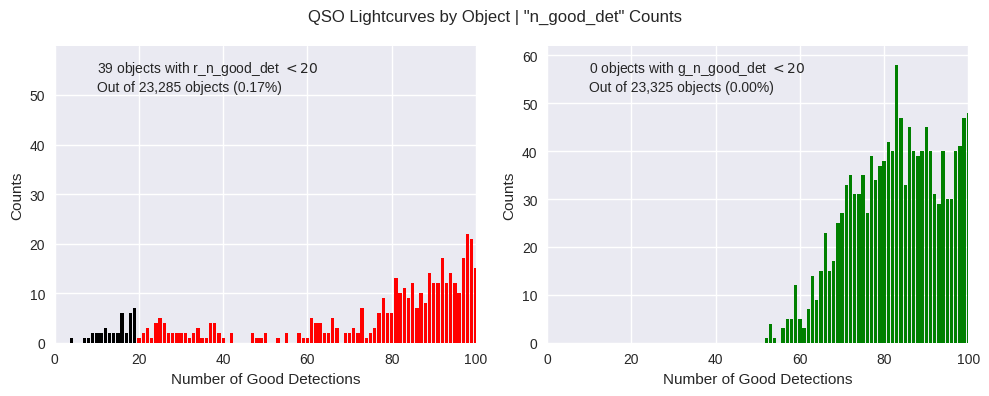

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 5, 4))

r_lightcurves_by_object_value_counts = lightcurves_by_object_QSOs['r_n_good_det'].value_counts()

r_leq_than_20_counts = r_lightcurves_by_object_value_counts[r_lightcurves_by_object_value_counts.index < 20].sum()
r_all_counts = r_lightcurves_by_object_value_counts.sum()

r_n_good_dets, r_counts = r_lightcurves_by_object_value_counts.index, r_lightcurves_by_object_value_counts.values
r_colors = ['black' if det < 20 else 'red' for det in r_n_good_dets]


g_lightcurves_by_object_value_counts = lightcurves_by_object_QSOs['g_n_good_det'].value_counts()

g_leq_than_20_counts = g_lightcurves_by_object_value_counts[g_lightcurves_by_object_value_counts.index < 20].sum()
g_all_counts = g_lightcurves_by_object_value_counts.sum()

g_n_good_dets, g_counts = g_lightcurves_by_object_value_counts.index, g_lightcurves_by_object_value_counts.values
g_colors = ['black' if det < 20 else 'green' for det in g_n_good_dets]

axs[0].bar(r_n_good_dets, r_counts, color=r_colors)
axs[0].text(0.1, 0.85, f'{r_leq_than_20_counts:,d} objects with r_n_good_det $< 20$\nOut of {r_all_counts:,d} objects ({r_leq_than_20_counts / r_all_counts:.2%})', transform=axs[0].transAxes)
axs[0].set_xlim(0, 100)
axs[0].set_xlabel('Number of Good Detections')
axs[0].set_ylabel('Counts')

axs[1].bar(g_n_good_dets, g_counts, color=g_colors)
axs[1].text(0.1, 0.85, f'{g_leq_than_20_counts:,d} objects with g_n_good_det $< 20$\nOut of {g_all_counts:,d} objects ({g_leq_than_20_counts / g_all_counts:.2%})', transform=axs[1].transAxes)
axs[1].set_xlim(0, 100)
axs[1].set_xlabel('Number of Good Detections')
axs[1].set_ylabel('Counts')

fig.suptitle('QSO Lightcurves by Object | "n_good_det" Counts', )

plt.tight_layout()
plt.show()

### Saving Features DFs

In [46]:
lightcurves_by_oid = pd.read_pickle(filtered_lightcurves_by_oid_pkl)
lightcurves_by_object = pd.read_pickle(filtered_lightcurves_by_name_pkl)

#### Saving Features by OID
We will merge the type column from the panstarrs DF to it as well.

In [47]:
features_junk_columns = ['timespan_good', 'T2020_sigma2']
# features_r = pd.read_csv(original_features_rband_csv, index_col=0, usecols=lambda col: col not in features_junk_columns)
# features_g = pd.read_csv(original_features_gband_csv, index_col=0, usecols=lambda col: col not in features_junk_columns)
features_r = pd.read_csv(original_features_rband_csv, index_col=0)
features_g = pd.read_csv(original_features_gband_csv, index_col=0)
features_r['band'], features_g['band'] = 'r', 'g'
features = pd.concat([features_r, features_g], axis=0, ignore_index=True)

features_r, features_g = np.nan, np.nan

features

,oid_alerce,name,meanra,meandec,n_good_det,timespan_good,T2020_sigma2,mhps_ratio,mhps_low,mhps_high,mhps_non_zero,mhps_PN_flag,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,Con,Eta_e,Gskew,MaxSlope,Mean,Meanvariance,MedianAbsDev,MedianBRP,PairSlopeTrend,PercentAmplitude,Q31,PeriodLS_v2,Period_fit_v2,Psi_CS_v2,Psi_eta_v2,Rcs,Skew,SmallKurtosis,Std,StetsonK,Pvar,ExcessVar,GP_DRW_sigma,GP_DRW_tau,SF_ML_amplitude,SF_ML_gamma,IAR_phi,LinearTrend,Harmonics_mag_1,Harmonics_mag_2,Harmonics_mag_3,Harmonics_mag_4,Harmonics_mag_5,Harmonics_mag_6,Harmonics_mag_7,Harmonics_phase_2,Harmonics_phase_3,Harmonics_phase_4,Harmonics_phase_5,Harmonics_phase_6,Harmonics_phase_7,Harmonics_mse,band
0,748205400021910,SDSS J081739.86+460259.9,124.416067,46.050017,279,1100.017338,0.011807,12.864834,0.104130,0.008094,273,0,0.260285,0.771675,11.0,0.322581,0.003610,0.757700,-0.020399,280.700045,19.360588,0.007084,0.093271,0.498208,-0.033333,0.027606,0.176163,0.996214,0.058242,0.180673,1.426987,0.322325,-0.005069,0.491462,0.137159,0.797153,1.000000,0.000031,0.018114,187.526336,0.204974,0.322065,0.994903,0.000034,0.110798,0.016199,0.018633,0.014556,0.006872,0.007870,0.009743,1.627740,2.324921,6.131167,3.125166,3.152284,1.345262,1.230803e-02,r
1,1443216100009226,SDSS J010838.16+043023.7,17.159044,4.506617,33,476.747616,0.001327,10.967492,0.013710,0.001250,26,0,0.082948,0.971303,1.0,0.303030,0.000000,1.091843,-0.055809,272.390787,17.810544,0.002502,0.025982,0.424242,-0.166667,0.006586,0.066933,0.067910,0.002868,0.242662,1.293717,0.231568,-0.548563,-0.223483,0.044559,0.837170,1.000000,0.000004,0.001327,3.034985,0.167417,0.494280,0.437182,-0.000058,0.045269,0.050801,0.036804,0.034195,0.046047,0.032903,0.022891,4.416530,3.056699,2.213452,1.211651,0.696074,5.900019,5.719619e-04,r
2,256209100009604,[MML2015] 5BZQ J0544-2241,86.031521,-22.686088,83,902.616840,0.001164,7.897186,0.001210,0.000153,77,0,0.060822,1.000000,17.0,0.397590,0.000000,0.256926,-0.021135,32.865486,16.189677,0.002304,0.026810,0.240964,0.100000,0.004547,0.066277,0.997904,0.121620,0.260431,0.519078,0.415016,-0.241761,-1.189920,0.037298,0.878972,1.000000,0.000004,0.000748,5.046776,0.020893,0.179884,0.999181,0.000101,7.575869,6.155229,4.311862,2.547361,1.214377,0.442628,0.098353,3.146195,0.010982,3.151621,0.000952,3.156961,6.186866,2.351516e-04,r
3,756209200005885,SDSS J131329.82+484800.4,198.374283,48.800151,371,1130.888368,0.002192,4.054112,0.033504,0.008264,359,1,0.207830,0.585693,1.0,0.312668,0.000000,1.258154,-0.005106,350.238325,19.634425,0.005766,0.074381,0.539084,-0.033333,0.021141,0.150362,1.000801,0.025075,0.120430,1.500123,0.216538,0.083415,0.505152,0.113215,0.798243,0.999605,0.000006,0.004264,67.424130,0.058838,0.157345,0.997126,0.000135,0.071792,0.013477,0.024859,0.003133,0.014462,0.005134,0.005545,1.786497,0.722402,1.209765,6.212635,3.005889,2.858621,9.943191e-03,r
4,1670209300009099,SDSS J125756.90+295134.3,194.487139,29.859566,7,129.782824,0.030260,NaN,0.179604,NaN,0,1,0.325623,0.406842,1.0,0.285714,0.000000,1.323021,-0.243511,0.109787,20.144384,0.009714,0.123444,0.428571,0.000000,0.022139,0.206116,0.152425,0.046257,0.333923,2.268062,0.318975,-0.684564,3.333258,0.195689,0.805076,0.999280,0.000059,0.028259,2.367229,0.209882,0.000014,0.676934,0.001541,1.210583,2.074339,2.513448,6.225159,2.336429,3.754811,5.156053,3.272485,3.657783,2.027505,6.090577,2.086239,2.335166,4.038968e-28,r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113891,550109100014580,SDSS J001817.31+195418.3,4.572160,19.905072,95,943.667593,0.013511,19.842649,0.281342,0.014179,82,0,0.388743,0.881881,3.0,0.284211,0.000000,0.094686,-0.077349,57.059919,20.115172,0.009240,0.117031,0.463158,0.100000,0.026094,0.224570,0.499451,0.008322,0.202570,1.073432,0.284496,-0.094705,0.699918,0.185865,0.748655,1.000000,0.000032,0.020248,50.725

In [48]:
features.columns

Index(['oid_alerce', 'name', 'meanra', 'meandec', 'n_good_det',
       'timespan_good', 'T2020_sigma2', 'mhps_ratio', 'mhps_low', 'mhps_high',
       'mhps_non_zero', 'mhps_PN_flag', 'Amplitude', 'AndersonDarling',
       'Autocor_length', 'Beyond1Std', 'Con', 'Eta_e', 'Gskew', 'MaxSlope',
       'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend',
       'PercentAmplitude', 'Q31', 'PeriodLS_v2', 'Period_fit_v2', 'Psi_CS_v2',
       'Psi_eta_v2', 'Rcs', 'Skew', 'SmallKurtosis', 'Std', 'StetsonK', 'Pvar',
       'ExcessVar', 'GP_DRW_sigma', 'GP_DRW_tau', 'SF_ML_amplitude',
       'SF_ML_gamma', 'IAR_phi', 'LinearTrend', 'Harmonics_mag_1',
       'Harmonics_mag_2', 'Harmonics_mag_3', 'Harmonics_mag_4',
       'Harmonics_mag_5', 'Harmonics_mag_6', 'Harmonics_mag_7',
       'Harmonics_phase_2', 'Harmonics_phase_3', 'Harmonics_phase_4',
       'Harmonics_phase_5', 'Harmonics_phase_6', 'Harmonics_phase_7',
       'Harmonics_mse', 'band'],
      dtype='object')

In [49]:
print(f'There are {features.query("band == 'r'").shape[0]:,} r band OIDs.')
print(f'There are {features.query("band == 'g'").shape[0]:,} g band OIDs.')

There are 60,596 r band OIDs.
There are 53,300 g band OIDs.


In [50]:
features = features.merge(right=panstarrs, how='inner').replace([np.inf, -np.inf], np.nan)
features.rename(columns={'meanra': 'ra', 'meandec': 'dec'}, inplace=True)
features

,oid_alerce,name,ra,dec,n_good_det,timespan_good,T2020_sigma2,mhps_ratio,mhps_low,mhps_high,mhps_non_zero,mhps_PN_flag,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,Con,Eta_e,Gskew,MaxSlope,Mean,Meanvariance,MedianAbsDev,MedianBRP,PairSlopeTrend,PercentAmplitude,Q31,PeriodLS_v2,Period_fit_v2,Psi_CS_v2,Psi_eta_v2,Rcs,Skew,SmallKurtosis,Std,StetsonK,Pvar,ExcessVar,GP_DRW_sigma,GP_DRW_tau,SF_ML_amplitude,SF_ML_gamma,IAR_phi,LinearTrend,Harmonics_mag_1,Harmonics_mag_2,Harmonics_mag_3,Harmonics_mag_4,Harmonics_mag_5,Harmonics_mag_6,Harmonics_mag_7,Harmonics_phase_2,Harmonics_phase_3,Harmonics_phase_4,Harmonics_phase_5,Harmonics_phase_6,Harmonics_phase_7,Harmonics_mse,band,type,z
0,748205400021910,SDSS J081739.86+460259.9,124.416067,46.050017,279,1100.017338,0.011807,12.864834,0.104130,0.008094,273,0,0.260285,0.771675,11.0,0.322581,0.003610,0.757700,-0.020399,280.700045,19.360588,0.007084,0.093271,0.498208,-0.033333,0.027606,0.176163,0.996214,0.058242,0.180673,1.426987,0.322325,-0.005069,0.491462,0.137159,0.797153,1.000000,0.000031,0.018114,187.526336,0.204974,0.322065,0.994903,0.000034,0.110798,0.016199,0.018633,0.014556,0.006872,0.007870,0.009743,1.627740,2.324921,6.131167,3.125166,3.152284,1.345262,1.230803e-02,r,Q,1.520
1,1443216100009226,SDSS J010838.16+043023.7,17.159044,4.506617,33,476.747616,0.001327,10.967492,0.013710,0.001250,26,0,0.082948,0.971303,1.0,0.303030,0.000000,1.091843,-0.055809,272.390787,17.810544,0.002502,0.025982,0.424242,-0.166667,0.006586,0.066933,0.067910,0.002868,0.242662,1.293717,0.231568,-0.548563,-0.223483,0.044559,0.837170,1.000000,0.000004,0.001327,3.034985,0.167417,0.494280,0.437182,-0.000058,0.045269,0.050801,0.036804,0.034195,0.046047,0.032903,0.022891,4.416530,3.056699,2.213452,1.211651,0.696074,5.900019,5.719619e-04,r,AX,0.160
2,256209100009604,[MML2015] 5BZQ J0544-2241,86.031521,-22.686088,83,902.616840,0.001164,7.897186,0.001210,0.000153,77,0,0.060822,1.000000,17.0,0.397590,0.000000,0.256926,-0.021135,32.865486,16.189677,0.002304,0.026810,0.240964,0.100000,0.004547,0.066277,0.997904,0.121620,0.260431,0.519078,0.415016,-0.241761,-1.189920,0.037298,0.878972,1.000000,0.000004,0.000748,5.046776,0.020893,0.179884,0.999181,0.000101,7.575869,6.155229,4.311862,2.547361,1.214377,0.442628,0.098353,3.146195,0.010982,3.151621,0.000952,3.156961,6.186866,2.351516e-04,r,QSO RLoud flat radio sp.,1.537
3,756209200005885,SDSS J131329.82+484800.4,198.374283,48.800151,371,1130.888368,0.002192,4.054112,0.033504,0.008264,359,1,0.207830,0.585693,1.0,0.312668,0.000000,1.258154,-0.005106,350.238325,19.634425,0.005766,0.074381,0.539084,-0.033333,0.021141,0.150362,1.000801,0.025075,0.120430,1.500123,0.216538,0.083415,0.505152,0.113215,0.798243,0.999605,0.000006,0.004264,67.424130,0.058838,0.157345,0.997126,0.000135,0.071792,0.013477,0.024859,0.003133,0.014462,0.005134,0.005545,1.786497,0.722402,1.209765,6.212635,3.005889,2.858621,9.943191e-03,r,Q,1.650
4,1670209300009099,SDSS J125756.90+295134.3,194.487139,29.859566,7,129.782824,0.030260,NaN,0.179604,NaN,0,1,0.325623,0.406842,1.0,0.285714,0.000000,1.323021,-0.243511,0.109787,20.144384,0.009714,0.123444,0.428571,0.000000,0.022139,0.206116,0.152425,0.046257,0.333923,2.268062,0.318975,-0.684564,3.333258,0.195689,0.805076,0.999280,0.000059,0.028259,2.367229,0.209882,0.000014,0.676934,0.001541,1.210583,2.074339,2.513448,6.225159,2.336429,3.754811,5.156053,3.272485,3.657783,2.027505,6.090577,2.086239,2.335166,4.038968e-28,r,Q,2.090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113891,550109100014580,SDSS J001817.31+195418.3,4.572160,19.905072,95,943.667593,0.013511,19.842649,0.281342,0.014179,82,0,0.388743,0.881881,3.0,0.284211,0.000000,0.094686,-0.077349,57.059919,20.115172,0.009240,0.117031,0.463158,0.100000,0.026094,0.224570,0.499451,0.008322,0.202570,1.073432,0.284496

In [51]:
print(f'Post-merging with PANSTARRS, are {features.query("band == 'r'").shape[0]:,} r band OIDs.')
print(f'Post-merging with PANSTARRS, are {features.query("band == 'g'").shape[0]:,} g band OIDs.')

Post-merging with PANSTARRS, are 60,596 r band OIDs.
Post-merging with PANSTARRS, are 53,300 g band OIDs.


In [52]:
na_column_numbers = features.isna().sum()

for index, value in na_column_numbers.items():
    if value != 0:
        print(f'The column {index} has {value} NA values')

The column mhps_ratio has 5367 NA values
The column mhps_low has 677 NA values
The column mhps_high has 5367 NA values
The column Period_fit_v2 has 785 NA values
The column z has 1954 NA values


In [53]:
features.to_parquet(original_features_by_oid_parquet)
# features = pd.read_parquet(original_features_by_oid_parquet)

#### Saving features by Object.
Let's now make a DF with averaged values for each object per band.

In [54]:
float_properties = ['T2020_sigma2', 'mhps_ratio', 'mhps_low', 'mhps_high', 'Amplitude', 'AndersonDarling', 'Autocor_length',
                    'Beyond1Std', 'Con', 'Eta_e', 'Gskew', 'MaxSlope', 'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend',
                    'PercentAmplitude', 'Q31', 'PeriodLS_v2', 'Period_fit_v2', 'Psi_CS_v2', 'Psi_eta_v2', 'Rcs', 'Skew', 'SmallKurtosis',
                    'Std', 'StetsonK', 'Pvar', 'ExcessVar', 'GP_DRW_sigma', 'GP_DRW_tau', 'SF_ML_amplitude', 'SF_ML_gamma', 'IAR_phi',
                    'LinearTrend', 'Harmonics_mag_1', 'Harmonics_mag_2', 'Harmonics_mag_3', 'Harmonics_mag_4', 'Harmonics_mag_5',
                    'Harmonics_mag_6', 'Harmonics_mag_7', 'Harmonics_phase_2', 'Harmonics_phase_3', 'Harmonics_phase_4', 'Harmonics_phase_5',
                    'Harmonics_phase_6', 'Harmonics_phase_7', 'Harmonics_mse']

integer_properties = ['mhps_non_zero', 'mhps_PN_flag']

def weighted_average(column, weights):
    column, weights = column.to_numpy(), weights.to_numpy()
    
    mask = np.isfinite(column) & np.isfinite(weights)
    if mask.sum() == 0:
        return np.nan
    
    column, weights = column[mask], weights[mask]
    normalised_weights = weights / sum(weights)
    return (column * normalised_weights).sum()

In [55]:
name_grouped = features.groupby(by='name', observed=True)
features_dict_list = []

for name, name_df in tqdm(name_grouped):
    lightcurve_df = lightcurves_by_object.query("name == @name")
    object_dict = {'name': name, 'type': name_df.type.iloc[0], 'z': name_df.z.mean(), 'ra': name_df.ra.mean(), 'dec': name_df.dec.mean()}

    name_band_grouped = name_df.groupby(by='band', observed=True)
    for band, name_band_df in name_band_grouped:
        averaged_properties = name_band_df[float_properties + integer_properties].apply(func=weighted_average, axis=0, args=(name_band_df['n_good_det'],))
        averaged_properties['timespan_good'] = lightcurve_df[f"{band}_timespan_good"].iloc[0] if not lightcurve_df.empty else np.nan
        averaged_properties['n_good_det'] = lightcurve_df[f"{band}_n_good_det"].iloc[0] if not lightcurve_df.empty else name_band_df.n_good_det.sum()

        for integer_property in integer_properties:
            averaged_properties[integer_property] = round(averaged_properties[integer_property])
        averaged_properties = averaged_properties.add_prefix(f"{band}_")

        object_dict.update(averaged_properties.to_dict())
        
    features_dict_list.append(object_dict)

  0%|          | 0/32187 [00:00<?, ?it/s]

In [56]:
features_by_object = pd.DataFrame(features_dict_list).replace([np.inf, -np.inf], np.nan)
features, name_grouped, name_band_grouped, features_dict_list = np.nan, np.nan, np.nan, np.nan

features_by_object

,name,type,z,ra,dec,g_T2020_sigma2,g_mhps_ratio,g_mhps_low,g_mhps_high,g_Amplitude,g_AndersonDarling,g_Autocor_length,g_Beyond1Std,g_Con,g_Eta_e,g_Gskew,g_MaxSlope,g_Mean,g_Meanvariance,g_MedianAbsDev,g_MedianBRP,g_PairSlopeTrend,g_PercentAmplitude,g_Q31,g_PeriodLS_v2,g_Period_fit_v2,g_Psi_CS_v2,g_Psi_eta_v2,g_Rcs,g_Skew,g_SmallKurtosis,g_Std,g_StetsonK,g_Pvar,g_ExcessVar,g_GP_DRW_sigma,g_GP_DRW_tau,g_SF_ML_amplitude,g_SF_ML_gamma,g_IAR_phi,g_LinearTrend,g_Harmonics_mag_1,g_Harmonics_mag_2,g_Harmonics_mag_3,g_Harmonics_mag_4,g_Harmonics_mag_5,g_Harmonics_mag_6,g_Harmonics_mag_7,g_Harmonics_phase_2,g_Harmonics_phase_3,g_Harmonics_phase_4,g_Harmonics_phase_5,g_Harmonics_phase_6,g_Harmonics_phase_7,g_Harmonics_mse,g_mhps_non_zero,g_mhps_PN_flag,g_timespan_good,g_n_good_det,r_T2020_sigma2,r_mhps_ratio,r_mhps_low,r_mhps_high,r_Amplitude,r_AndersonDarling,r_Autocor_length,r_Beyond1Std,r_Con,r_Eta_e,r_Gskew,r_MaxSlope,r_Mean,r_Meanvariance,r_MedianAbsDev,r_MedianBRP,r_PairSlopeTrend,r_PercentAmplitude,r_Q31,r_PeriodLS_v2,r_Period_fit_v2,r_Psi_CS_v2,r_Psi_eta_v2,r_Rcs,r_Skew,r_SmallKurtosis,r_Std,r_StetsonK,r_Pvar,r_ExcessVar,r_GP_DRW_sigma,r_GP_DRW_tau,r_SF_ML_amplitude,r_SF_ML_gamma,r_IAR_phi,r_LinearTrend,r_Harmonics_mag_1,r_Harmonics_mag_2,r_Harmonics_mag_3,r_Harmonics_mag_4,r_Harmonics_mag_5,r_Harmonics_mag_6,r_Harmonics_mag_7,r_Harmonics_phase_2,r_Harmonics_phase_3,r_Harmonics_phase_4,r_Harmonics_phase_5,r_Harmonics_phase_6,r_Harmonics_phase_7,r_Harmonics_mse,r_mhps_non_zero,r_mhps_PN_flag,r_timespan_good,r_n_good_det
0,1AXG J000605+2031,AX,0.380,1.497482,20.523582,0.014273,48.594009,0.036875,0.000759,0.187775,1.000000,30.000000,0.458515,0.000000,0.016098,-0.044947,34.995681,17.375759,0.006959,0.119652,0.301310,-0.100000,0.013861,0.244995,0.998901,0.194086,0.216091,0.346945,0.421878,-0.102632,-1.336476,0.120920,0.893277,1.000000,0.000047,0.010518,236.708629,0.204162,0.583530,0.996871,0.000126,0.151894,0.007710,0.044154,0.016397,0.027046,0.015776,0.033828,5.854986,3.710896,1.449282,1.094966,4.394753,5.393157,0.002173,228.0,0.0,964.688067,229.0,0.009511,55.136662,0.019977,0.000362,0.161364,1.000000,31.000000,0.436937,0.000000,0.196892,-0.040915,112.653745,17.350199,0.005731,0.092588,0.288288,0.033333,0.011848,0.181997,0.998901,0.241428,0.233884,0.401532,0.411865,-0.157815,-1.221240,0.099436,0.884034,1.000000,0.000031,0.006687,350.761060,0.442767,1.191259,0.998046,0.000116,0.114938,0.036082,0.003784,0.029023,0.005840,0.013830,0.006282,3.829476,5.185228,1.220331,4.582281,4.064478,1.681244,0.001615,219.0,0.0,981.708229,222.0
1,1AXG J102337+1936,AX,0.400,155.906409,19.607233,0.069024,13.555205,0.139676,0.010414,0.481032,0.988601,19.947020,0.327815,0.000000,0.119426,0.062953,31.141812,19.274425,0.014371,0.213865,0.278146,-0.066556,0.037634,0.427079,0.969797,0.122972,0.244132,0.476288,0.386607,0.125306,-0.687145,0.276915,0.853845,1.000000,0.000184,0.062186,253.965903,0.393353,0.714877,0.996821,-0.000545,0.470488,0.137712,0.117348,0.151026,0.103346,0.112209,0.086566,1.895608,0.701281,2.724349,2.503499,6.024504,4.258132,0.013377,131.0,0.0,1125.946574,302.0,0.031190,8.904907,0.066063,0.009919,0.337007,0.908087,18.771505,0.317204,0.000000,0.232110,0.034854,75.410904,18.943312,0.010084,0.137382,0.333333,-0.062545,0.028357,0.281044,0.971078,0.108243,0.243572,0.533180,0.325024,0.170017,-0.454136,0.191031,0.834330,1.000000,0.000086,0.028154,171.297407,0.210453,0.461596,0.995001,-0.000470,0.234918,0.040692,0.084763,0.046978,0.064671,0.075361,0.040063,2.205334,3.047679,4.511674,4.020787,4.400450,3.810208,0.008894,162.0,0.0,1111.032025,372.0
2,1AXG J103934+5330,AX,0.220,159.898995,53.510778,0.022250,40.809330,0.104922,0.002583,0.326890,0.999878,21.818792,0.261745,0.016898,0.528878,0.250616,287.983584,18.931393,0.008801,0.090493,0.493289,-0.033333,0.029477,0.209829,0.958914,0.072625,0.231612,0.706475,0.321905,0.764602,0.628279,0.166630,0.792750,1.000000,0.000062,0.026628,115.508555,0.279076,0.529270,0.939581,0.000313,42.286268,70.051958,91.499886,2

In [57]:
num_objects_without_r_curves = int(features_by_object['r_n_good_det'].isna().value_counts()[True])
num_objects_without_g_curves = int(features_by_object['g_n_good_det'].isna().value_counts()[True])

print(f'There are {num_objects_without_r_curves} objects without r band lightcurves.')
print(f'There are {num_objects_without_g_curves} objects without g band lightcurves.')

There are 99 objects without r band lightcurves.
There are 375 objects without g band lightcurves.


In [58]:
features_by_object_with_both_band_curves =  features_by_object[~(features_by_object['r_n_good_det'].isna() | features_by_object['g_n_good_det'].isna())]

na_column_numbers = features_by_object_with_both_band_curves.isna().sum()

for index, value in na_column_numbers.items():
    if value != 0:
        print(f'For objects with lightcurves in both bands, the column {index} has {value} NA values')

del features_by_object_with_both_band_curves

For objects with lightcurves in both bands, the column z has 583 NA values
For objects with lightcurves in both bands, the column g_mhps_ratio has 172 NA values
For objects with lightcurves in both bands, the column g_mhps_low has 47 NA values
For objects with lightcurves in both bands, the column g_mhps_high has 172 NA values
For objects with lightcurves in both bands, the column g_Period_fit_v2 has 22 NA values
For objects with lightcurves in both bands, the column g_timespan_good has 24 NA values
For objects with lightcurves in both bands, the column r_mhps_ratio has 32 NA values
For objects with lightcurves in both bands, the column r_mhps_low has 5 NA values
For objects with lightcurves in both bands, the column r_mhps_high has 32 NA values
For objects with lightcurves in both bands, the column r_Period_fit_v2 has 2 NA values
For objects with lightcurves in both bands, the column r_timespan_good has 24 NA values


In [59]:
features_by_object.to_parquet(original_features_by_name_parquet)
del features_by_object

# features_by_object = pd.read_parquet(original_features_by_name_parquet)